<h1><center> European Football Analysis & Data Visualization</center></h1>
In this project, we will take a look at

- FIFA Players Analysis- taking into account their different traits and styles of play
- avg overall rating according to player height 
- Manchester United $vs.$ Manchester City
- Cristiano Ronaldo $vs.$ Lionel Messi - taking into account their different traits and styles of play
- Data Visualization and Analysis
- SQL in Python

# <center>1.  Importing Libraries</center>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3 # SQLite 
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
#from customplot import *

# <center> 2. Data Ingestion<center>
> ## 2.1 Create Connection to the Database

In [2]:
# Create connection
database_connection = sqlite3.connect("database.sqlite")

> ## 2.2 Import SQL Tables

In [3]:
# Select all tables
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table'; """, database_connection)
# Check if tables were read successfully
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


> ## 2.3 Let's Select Individual Data Tables

In [4]:
# Player Attributes Table
Player_Attributes = pd.read_sql_query("""SELECT * 
                                         FROM Player_Attributes
                                         """, database_connection)
# Players Table
Player = pd.read_sql("""SELECT *
                        FROM Player
                        """, database_connection)

# Matches Table
Match = pd.read_sql("""SELECT *
                       FROM Match
                       """, database_connection)

# Leagues Table
League = pd.read_sql("""SELECT *
                        FROM League
                        """, database_connection)

# Countries Table
Country = pd.read_sql("""SELECT *
                         FROM Country
                         """, database_connection)

# Team Table
Team = pd.read_sql("""SELECT *
                      FROM Team
                      """, database_connection)

# Team Attributes Table
Team_Attributes = pd.read_sql("""SELECT *
                                 FROM Team_Attributes
                                 """, database_connection)

# <center>3. Exploratory Data Analysis</center>
> ## 3.1 Shape of the tables: How many rowsin each table?

In [5]:
print("Players Attributes Table has", Player_Attributes.shape[0], "rows.")
print("Players table has", Player.shape[0], "rows.")
print("Matches Tables has", Match.shape[0], "rows.")
print("Leagues Table has",League.shape[0], "rows.")
print("Countries Table has", Country.shape[0], "rows.")
print("Teams has",Team.shape[0], "rows.")
print("Teams Attributes has",Team_Attributes.shape[0], "rows.")

Players Attributes Table has 183978 rows.
Players table has 11060 rows.
Matches Tables has 25979 rows.
Leagues Table has 11 rows.
Countries Table has 11 rows.
Teams has 299 rows.
Teams Attributes has 1458 rows.


> ## 3. 2 A look at included Countries and their leagues

In [6]:
leagues = pd.read_sql("""SELECT *
                        FROM League
                        JOIN Country ON Country.id = League.country_id;""", database_connection)
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


In [7]:
print("Countries are:\n")
col = Country["name"]
for i in col:
    print("\t", i)

Countries are:

	 Belgium
	 England
	 France
	 Germany
	 Italy
	 Netherlands
	 Poland
	 Portugal
	 Scotland
	 Spain
	 Switzerland


>> ### 3.2.1 Merge Country Table with League Table

In [8]:
# Concatenate Country and League Tables
merged = pd.concat([Country, League], axis=1)

>> ### 3.2.2 Drop `id`, `country_id`

In [9]:
# Drop some columns
merged = merged.drop(["id", "country_id"], axis=1)

>> ### 3.2.3 Rename Columns

In [10]:
# Changing columns name with index number
merged.columns.values[0] = "Country Name"
merged.columns.values[1] = "League"
merged

,Country Name,League
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


> ## 3.3 Players Analysis
>> ### 3.3.1 A look at the Player Table

In [11]:
# View first 5 entries
Player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


>> ### 3.3.2 Let's `LEFT JOIN` Player Table with Player Attributes Table
- We will re-read the SQL Database again, calling players attributes that show attacking potential
- Then Select the year 2014

In [12]:
# Read SQL: LEFT JOIN Player_Attributes and Player Tables 
player_atts = pd.read_sql("""SELECT player_name,
                                    birthday,
                                    date,
                                    overall_rating,
                                    height,
                                    attacking_work_rate,
                                    crossing,
                                    finishing,
                                    shot_power,
                                    heading_accuracy,
                                    sprint_speed,
                                    agility,
                                    dribbling,
                                    reactions,
                                    defensive_work_rate,
                                    preferred_foot,
                                    free_kick_accuracy,
                                    stamina,
                                    penalties
                             FROM Player
                             LEFT JOIN Player_Attributes
                             ON Player_Attributes.player_api_id = Player.player_api_id
                             WHERE date LIKE '2014%'
                             ORDER BY date
                             """, database_connection)
# Peak at the first 5 entries
player_atts.head()

,player_name,birthday,date,overall_rating,height,attacking_work_rate,crossing,finishing,shot_power,heading_accuracy,sprint_speed,agility,dribbling,reactions,defensive_work_rate,preferred_foot,free_kick_accuracy,stamina,penalties
0,Aaron Meijers,1987-10-28 00:00:00,2014-01-03 00:00:00,67.0,175.26,medium,65.0,41.0,66.0,58.0,75.0,69.0,69.0,69.0,medium,left,66.0,77.0,55.0
1,Achille Emana,1982-06-05 00:00:00,2014-01-03 00:00:00,73.0,180.34,medium,64.0,70.0,79.0,61.0,64.0,67.0,73.0,72.0,low,right,71.0,55.0,72.0
2,Adam Lallana,1988-05-10 00:00:00,2014-01-03 00:00:00,79.0,172.72,high,75.0,70.0,68.0,67.0,76.0,84.0,84.0,73.0,medium,right,66.0,80.0,61.0
3,Adam Morgan,1994-04-21 00:00:00,2014-01-03 00:00:00,63.0,177.80,medium,39.0,67.0,61.0,57.0,79.0,64.0,61.0,59.0,medium,left,42.0,59.0,66.0
4,Adama Traore,1990-02-03 00:00:00,2014-01-03 00:00:00,62.0,170.18,high,63.0,51.0,65.0,52.0,85.0,73.0,61.0,42.0,medium,left,33.0,70.0,52.0


>> ### 3.3.3 How many rows and columns In the $player$_$atts$ dataframe?

In [13]:
# Dataframe shape: how many rows and columns in the given dataset?
print("There are", player_atts.shape[0], "rows/entries and", player_atts.shape[1], "features in our dataframe.")

There are 32808 rows/entries and 19 features in our dataframe.


>> ### 3.3.4 Features Data types

In [14]:
# Data types
player_atts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32808 entries, 0 to 32807
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_name          32808 non-null  object 
 1   birthday             32808 non-null  object 
 2   date                 32808 non-null  object 
 3   overall_rating       32792 non-null  float64
 4   height               32808 non-null  float64
 5   attacking_work_rate  32792 non-null  object 
 6   crossing             32792 non-null  float64
 7   finishing            32792 non-null  float64
 8   shot_power           32792 non-null  float64
 9   heading_accuracy     32792 non-null  float64
 10  sprint_speed         32792 non-null  float64
 11  agility              32792 non-null  float64
 12  dribbling            32792 non-null  float64
 13  reactions            32792 non-null  float64
 14  defensive_work_rate  32792 non-null  object 
 15  preferred_foot       32792 non-null 

>> ### 3.3.5 Are There Missing or Null values in our dataset?

In [15]:
# Null Values Check
player_atts.isnull().sum()

player_name             0
birthday                0
date                    0
overall_rating         16
height                  0
attacking_work_rate    16
crossing               16
finishing              16
shot_power             16
heading_accuracy       16
sprint_speed           16
agility                16
dribbling              16
reactions              16
defensive_work_rate    16
preferred_foot         16
free_kick_accuracy     16
stamina                16
penalties              16
dtype: int64

>> ### 3.3.6 Handling missing values- Deletion Method
- We will drop null rows

In [16]:
rows = player_atts.shape[0]

# Drop the NULL rows
player_atts = player_atts.dropna()

In [17]:
# Do we still have missing values?
player_atts.isnull().any().any(), player_atts.shape[0]

(False, 32792)

$\implies$ **How many rows did we drop?**

In [18]:
print("We dropped", rows - player_atts.shape[0], "rows with NULL values; that's about", round((16/32808)*100, 4),"% of the original dataframe")

We dropped 16 rows with NULL values; that's about 0.0488 % of the original dataframe


>> ### 3.3.7 Showing Basic Statistical Summary of the dataset 
- We will use `.describe()` function
  - $\implies$This function shows some basic descriptive statistics for all numeric columns
  - $\implies$ By default, this function only analyzes numeric columns, ut if we want to include other data types we can use the `include` parameter:

In [19]:
# Statistical Description of Numerical Values
player_atts.describe().T

,count,mean,std,min,25%,50%,75%,max
overall_rating,32792.0,68.944255,6.472284,40.00,65.0,69.00,73.00,94.00
height,32792.0,181.766000,6.395239,160.02,177.8,182.88,185.42,208.28
crossing,32792.0,56.210783,15.859415,8.00,46.0,60.00,68.00,91.00
finishing,32792.0,50.930379,17.644249,6.00,35.0,54.00,65.00,97.00
shot_power,32792.0,63.159582,15.191739,12.00,56.0,67.00,74.00,96.00
heading_accuracy,32792.0,58.077153,14.728564,10.00,50.0,60.00,68.00,95.00
sprint_speed,32792.0,68.325842,12.916988,20.00,62.0,70.00,77.00,97.00
agility,32792.0,66.343986,13.543602,16.00,58.0,68.00,76.00,95.00
dribbling,32792.0,60.916077,15.961245,6.00,54.0,65.00,72.00,97.00
reactions,32792.0,66.464199,8.732055,20.00,61.0,67.00,72.00,96.00


In [20]:
# Including object data types
player_atts.describe(include=np.object).T

C:\Users\avss4\AppData\Local\Temp\ipykernel_14628\691318938.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  player_atts.describe(include=np.object).T


,count,unique,top,freq
player_name,32792,7685,Danilo,32
birthday,32792,4439,1991-01-07 00:00:00,42
date,32792,51,2014-09-18 00:00:00,6429
attacking_work_rate,32792,4,medium,22285
defensive_work_rate,32792,13,medium,23858
preferred_foot,32792,2,right,24763


>> ### 3.3.8 Finding Duplicate Data

In [21]:
# Finding duplicates
dupli_df = player_atts.duplicated()
print("We have", dupli_df.sum(),"duplicates in this dataset.")

We have 0 duplicates in this dataset.


>> ### 3.3.9 Unique Entries under each Column

In [22]:
# Unique Values
player_atts.nunique()

player_name            7685
birthday               4439
date                     51
overall_rating           48
height                   19
attacking_work_rate       4
crossing                 84
finishing                89
shot_power               81
heading_accuracy         84
sprint_speed             78
agility                  76
dribbling                87
reactions                65
defensive_work_rate      13
preferred_foot            2
free_kick_accuracy       85
stamina                  78
penalties                84
dtype: int64

> ## 3.4 2014 Highly Rated Players in Different Attributes
>> ### 3.4.1 Which Players Were Rated 90 and above in 2014?

,player_name,overall_rating
748,Franck Ribery,90.0
1424,Cristiano Ronaldo,92.0
6732,Zlatan Ibrahimovic,90.0
13987,Lionel Messi,94.0
18565,Arjen Robben,90.0
21541,Lionel Messi,93.0
21781,Manuel Neuer,90.0


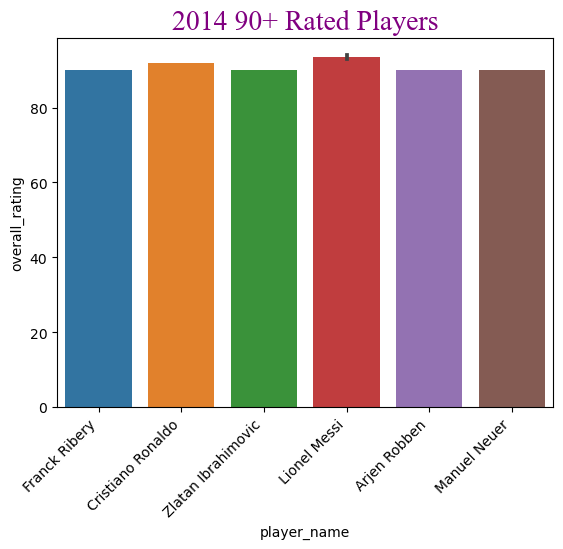

In [23]:
# Get 90+ Rated Players
high_rate = player_atts[player_atts.overall_rating>=90]
high_rate = pd.DataFrame(high_rate[["player_name", "overall_rating"]]).drop_duplicates()

# Plot 90+ Rated Players
barplot = sns.barplot(data = high_rate, x="player_name", y = "overall_rating")
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 90+ Rated Players", fontname ='Times New Roman', size = 20, color ='purple')
None #don't show the label objects

high_rate

$Observation$
- We see that Lionel Messi was the highest rated Player in 2014, with a rating of $94$.

>> ### 3.4.2 Which Players Were the Fastest Sprinters in 2014 $\implies$ $94+$ Pace?

,player_name,sprint_speed
454,Theo Walcott,96.0
1424,Cristiano Ronaldo,94.0
1769,Mathis Bolly,97.0
2689,Ryo Miyaichi,94.0
3092,Edwin Gyasi,94.0
3296,Jonathan Biabiany,94.0
3319,Juan Cuadrado,94.0
3547,Mohamed Salah,94.0
3628,Pierre-Emerick Aubameyang,95.0
3825,Victor Ibarbo,94.0


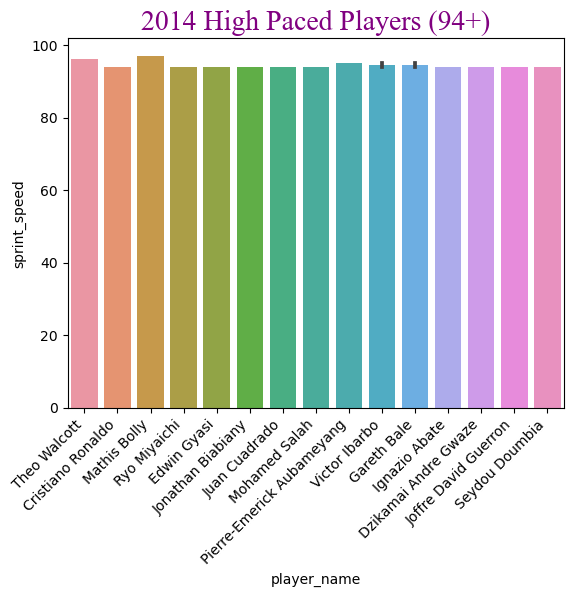

In [24]:
# Get 94+ Paced Players
high_pace = player_atts[player_atts.sprint_speed>=94]
high_pace = pd.DataFrame(high_pace[["player_name", "sprint_speed"]]).drop_duplicates()

# Plot 90+ Paced Players
pace_barplot = sns.barplot(data = high_pace, x="player_name", y = "sprint_speed")
pace_barplot.set_xticklabels(pace_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 High Paced Players (94+)", fontname ='Times New Roman', size = 20, color ='purple')
None #don't show the label objects

high_pace

>> ### 3.4.3 Which Players Were Prolific Penalty Takers in 2014 $\implies$ $90+$ Penalty Kick Rating?

In [25]:
high_penalty = player_atts[player_atts.penalties>=90]
high_penalty = high_penalty[["player_name", "penalties"]]
high_penalty = pd.DataFrame(high_penalty)
high_penalty = high_penalty.drop_duplicates()
high_penalty = high_penalty.sort_values(by="penalties", ascending=True)
high_penalty.style.set_table_attributes("style='display:inline'").set_caption('94+ Sprint Speed Players in 2014')
high_penalty

,player_name,penalties
397,Ryan Giggs,90.0
747,Francesco Totti,90.0
2291,Filip Daems,90.0
5098,Zlatan Ibrahimovic,91.0
2222,David Villa,92.0
21929,Mario Balotelli,92.0
7247,Mario Balotelli,93.0
4863,Rickie Lambert,94.0
2527,Mario Balotelli,95.0
12715,Rickie Lambert,95.0


$Observation$
- Mathis Bolly was the fastest player in 2014.

>> ### 3.4.4 Top Crossers, Finishers, Shot-Power, Sharp Headers, Dribblers, Reactive, Free Kick and Stamina Players

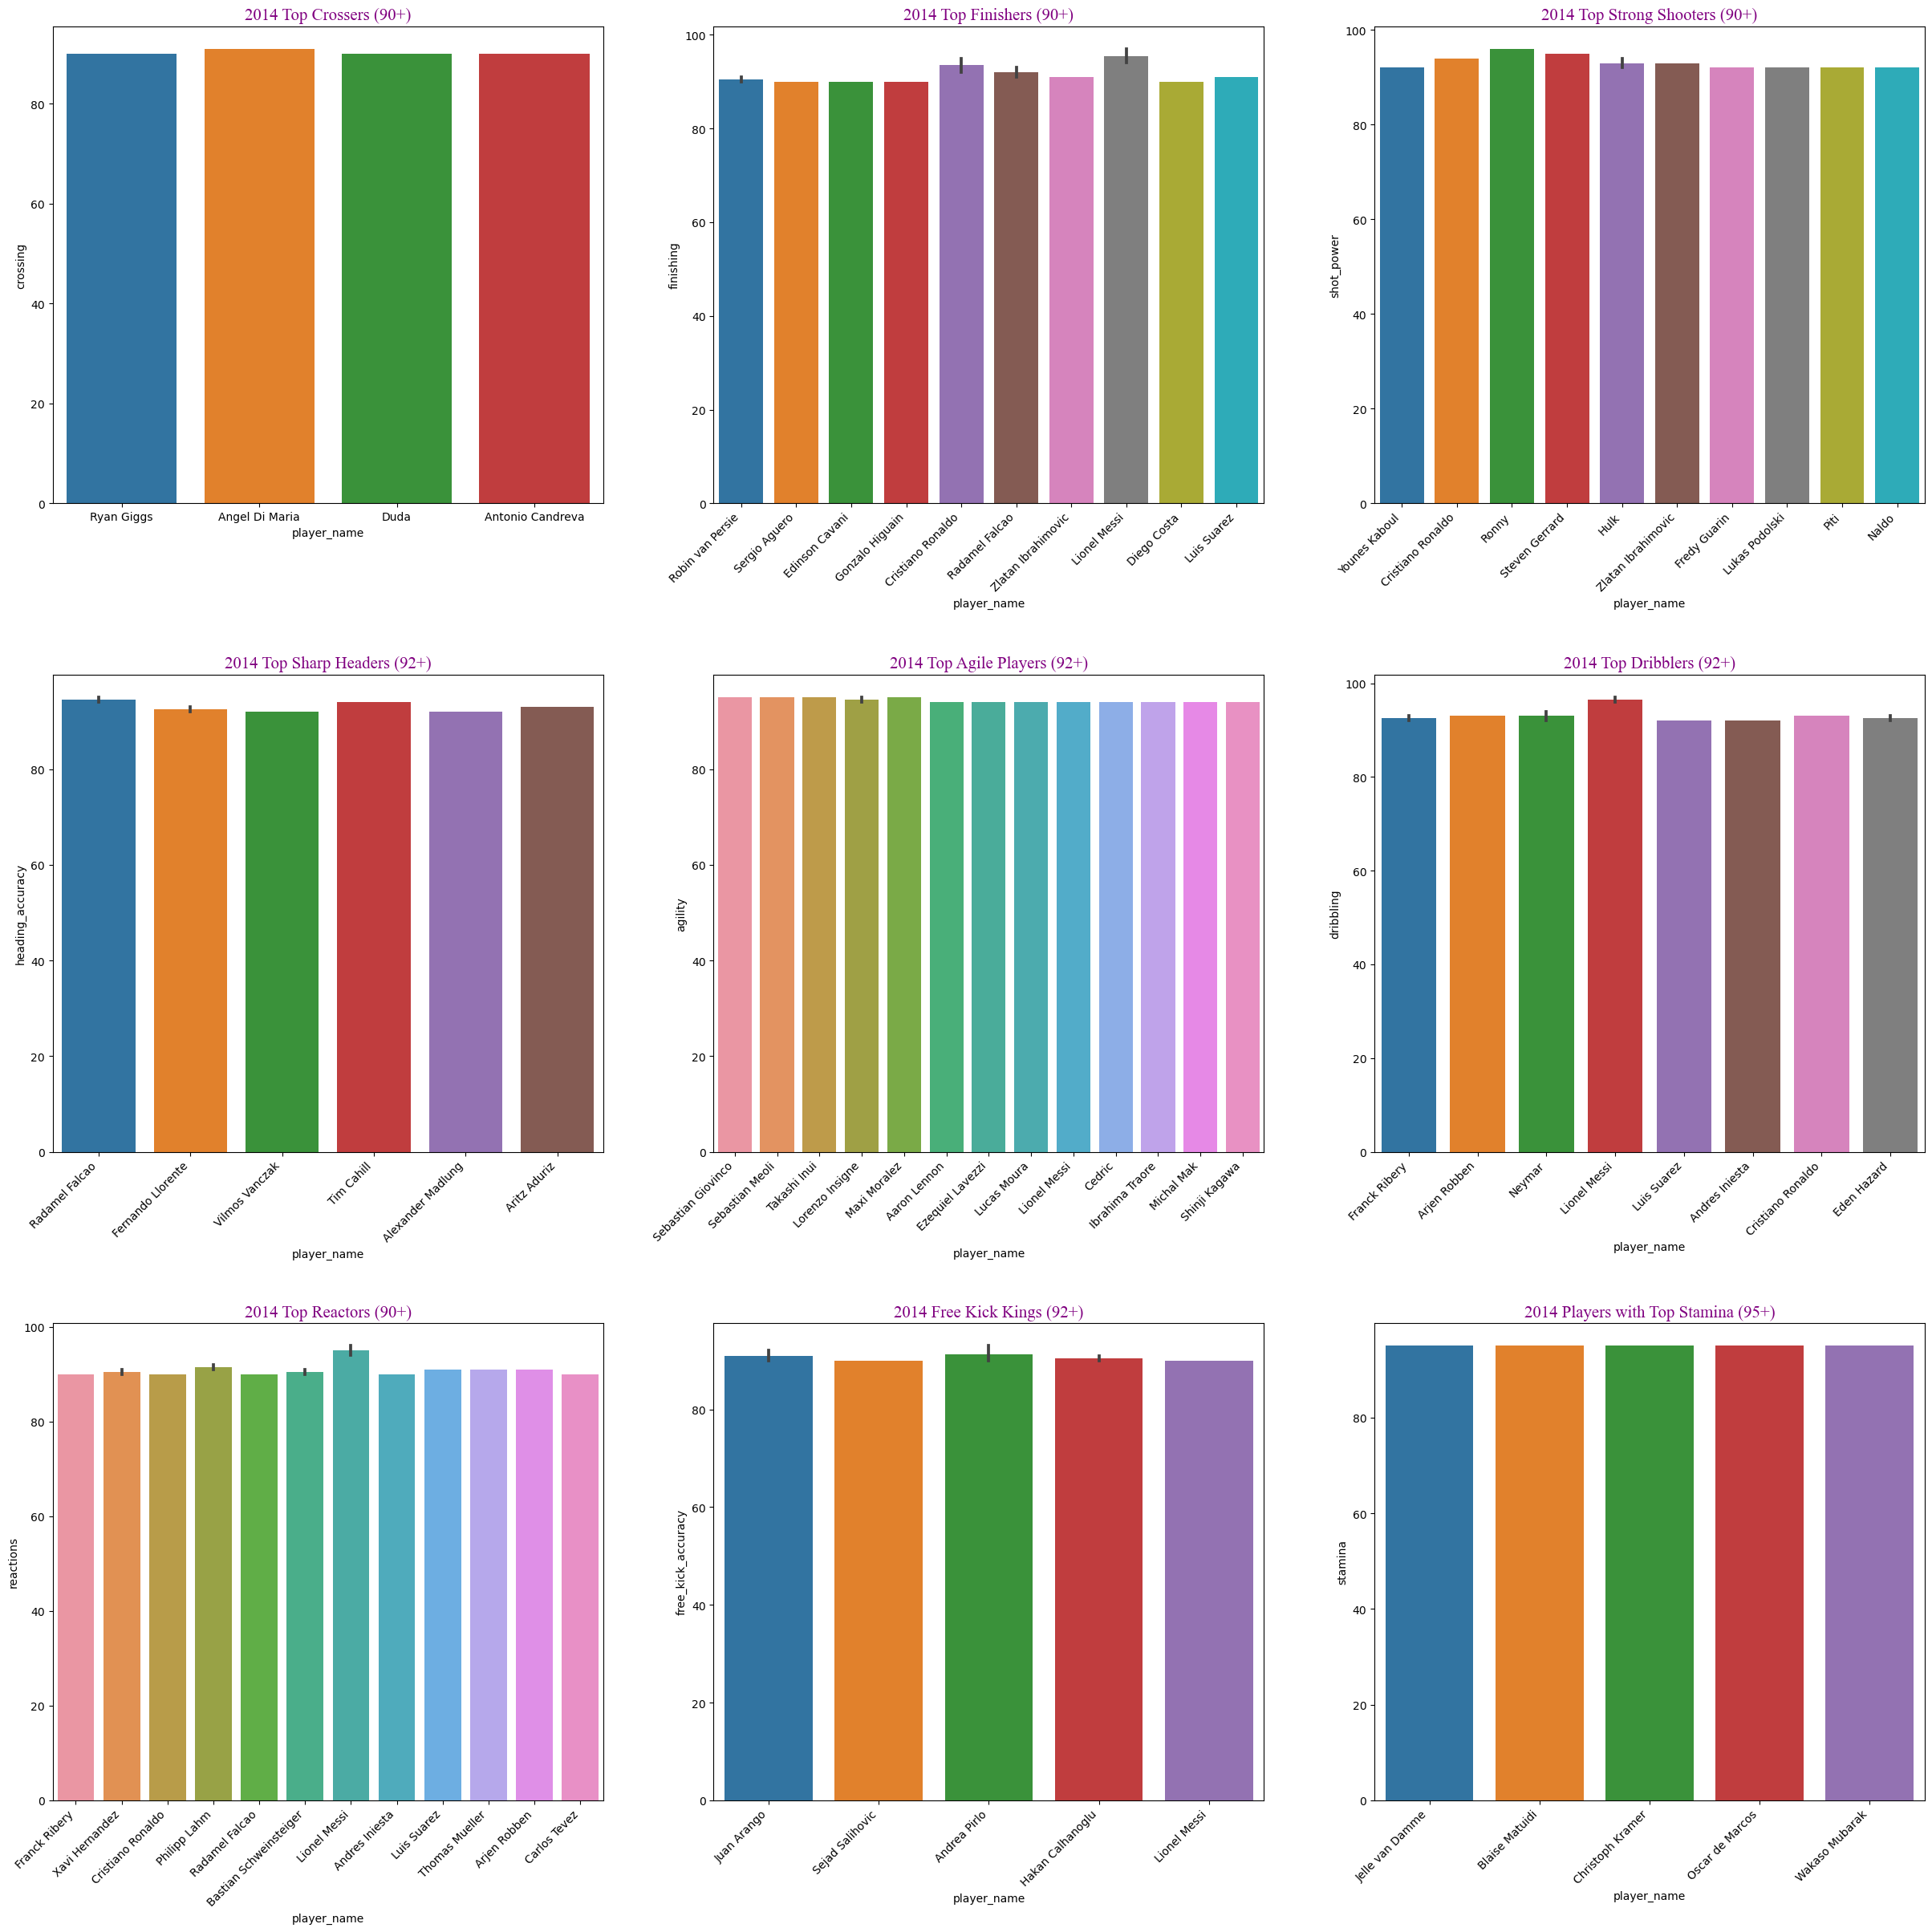

In [26]:
plt.figure(figsize=(25, 25))
# Crossing
crossing = player_atts[player_atts.crossing>=90]
crossing = pd.DataFrame(crossing[["player_name", "crossing"]]).drop_duplicates()
## Plot
plt.subplot(3, 3, 1)
crossing_barplot = sns.barplot(data = crossing, x="player_name", y = "crossing")
#crossing_barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Top Crossers (90+)", fontname ='Times New Roman', size = 15, color ='purple')
None #don't show the label objects

# Finishing
finishing = player_atts[player_atts.finishing>=90]
finishing = pd.DataFrame(finishing[["player_name", "finishing"]]).drop_duplicates()
## Plot
plt.subplot(3,3,2)
finishing_barplot = sns.barplot(data = finishing, x="player_name", y = "finishing")
finishing_barplot.set_xticklabels(finishing_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Top Finishers (90+)", fontname ='Times New Roman', size = 15, color ='purple')

# Shot Power
shot_power = player_atts[player_atts.shot_power>=92]
shot_power = pd.DataFrame(shot_power[["player_name", "shot_power"]]).drop_duplicates()
## Plot
plt.subplot(3,3,3)
shot_power_barplot = sns.barplot(data = shot_power, x="player_name", y = "shot_power")
shot_power_barplot.set_xticklabels(shot_power_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Top Strong Shooters (90+)", fontname ='Times New Roman', size = 15, color ='purple')

# Heading Accuracy
header = player_atts[player_atts.heading_accuracy>=92]
header = pd.DataFrame(header[["player_name", "heading_accuracy"]]).drop_duplicates()
## Plot
plt.subplot(3,3,4)
header_barplot = sns.barplot(data = header, x="player_name", y = "heading_accuracy")
header_barplot.set_xticklabels(header_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Top Sharp Headers (92+)", fontname ='Times New Roman', size = 15, color ='purple')

# Agility
agility = player_atts[player_atts.agility>=94]
agility = pd.DataFrame(agility[["player_name", "agility"]]).drop_duplicates()
## Plot
plt.subplot(3,3,5)
agility_barplot = sns.barplot(data = agility, x="player_name", y = "agility")
agility_barplot.set_xticklabels(agility_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Top Agile Players (92+)", fontname ='Times New Roman', size = 15, color ='purple')

# Dribbling
dribbling = player_atts[player_atts.dribbling>=92]
dribbling = pd.DataFrame(dribbling[["player_name", "dribbling"]]).drop_duplicates()
## Plot
plt.subplot(3,3,6)
dribbling_barplot = sns.barplot(data = dribbling, x="player_name", y = "dribbling")
dribbling_barplot.set_xticklabels(dribbling_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Top Dribblers (92+)", fontname ='Times New Roman', size = 15, color ='purple')

# Reactions
reactions = player_atts[player_atts.reactions>=90]
reactions = pd.DataFrame(reactions[["player_name", "reactions"]]).drop_duplicates()
## Plot
plt.subplot(3,3,7)
reactions_barplot = sns.barplot(data = reactions, x="player_name", y = "reactions")
reactions_barplot.set_xticklabels(reactions_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Top Reactors (90+)", fontname ='Times New Roman', size = 15, color ='purple')

print("\t")
# Free_kick Accuracy
free_kick_accuracy = player_atts[player_atts.free_kick_accuracy>=90]
free_kick_accuracy = pd.DataFrame(free_kick_accuracy[["player_name", "free_kick_accuracy"]]).drop_duplicates()
## Plot
plt.subplot(3,3,8)
free_kick_accuracy_barplot = sns.barplot(data = free_kick_accuracy, x="player_name", y = "free_kick_accuracy")
free_kick_accuracy_barplot.set_xticklabels(free_kick_accuracy_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Free Kick Kings (92+)", fontname ='Times New Roman', size = 15, color ='purple')


# Stamina 
stamina = player_atts[player_atts.stamina>=95]
stamina = pd.DataFrame(stamina[["player_name", "stamina"]]).drop_duplicates()
## Plot
plt.subplot(3,3,9)
stamina_barplot = sns.barplot(data = stamina, x="player_name", y = "stamina")
stamina_barplot.set_xticklabels(stamina_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("2014 Players with Top Stamina (95+)", fontname ='Times New Roman', size = 15, color ='purple')
#plt.annotate()

#plt.figure(figsize=(20, 15))
plt.tight_layout(pad=4.0)

> ## 3.5 Numerical Data Analysis
Numerical data is a type of data that is expressed in terms of numbers rather than natural language descriptions. Similar to its name, numerical, it can only be collected in number form. Also known as quantitative data, this numerical data type can be used as a form of measurement.
>> ### 3.5.1 Extracting Numerical Data

In [27]:
# get Numerical Data
numerical = player_atts.select_dtypes(exclude=["object"]).columns
df_num = player_atts[numerical]
df_num.head()

,overall_rating,height,crossing,finishing,shot_power,heading_accuracy,sprint_speed,agility,dribbling,reactions,free_kick_accuracy,stamina,penalties
0,67.0,175.26,65.0,41.0,66.0,58.0,75.0,69.0,69.0,69.0,66.0,77.0,55.0
1,73.0,180.34,64.0,70.0,79.0,61.0,64.0,67.0,73.0,72.0,71.0,55.0,72.0
2,79.0,172.72,75.0,70.0,68.0,67.0,76.0,84.0,84.0,73.0,66.0,80.0,61.0
3,63.0,177.80,39.0,67.0,61.0,57.0,79.0,64.0,61.0,59.0,42.0,59.0,66.0
4,62.0,170.18,63.0,51.0,65.0,52.0,85.0,73.0,61.0,42.0,33.0,70.0,52.0


>> ### 3.5.2 Numerical Feature Correlation Analysis

In [28]:
numFeat = ['height', 'crossing', 'finishing', 'shot_power',
            'heading_accuracy', 'sprint_speed', 'agility', 
            'dribbling', 'reactions','free_kick_accuracy', 
            'stamina', 'penalties']

# check how the features are correlated with the overall ratings 
for f in numFeat:
    corr = player_atts['overall_rating'].corr(player_atts[f])
    print("%s: %f" % (f,corr))

height: 0.002632
crossing: 0.345298
finishing: 0.342379
shot_power: 0.418087
heading_accuracy: 0.293389
sprint_speed: 0.190392
agility: 0.242399
dribbling: 0.353318
reactions: 0.803711
free_kick_accuracy: 0.366815
stamina: 0.244433
penalties: 0.361797


### $Analysis$ 
- We see that there is not significant correlation to overall rating as one would have thought.

In [29]:
# Covert Date Column to actual date format
player_atts['date'] = pd.to_datetime(player_atts['date'])

C:\Users\avss4\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='overall_rating'>

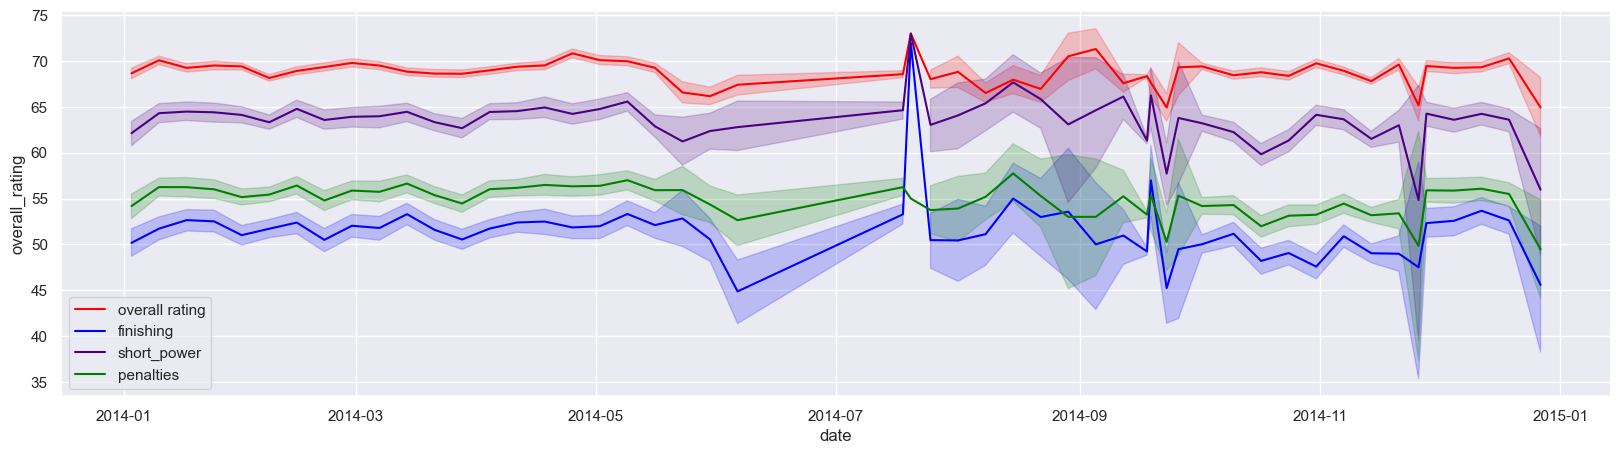

In [30]:
# Apply the default theme
sns.set()
plt.figure(figsize=(20, 5))
sns.lineplot(player_atts['date'],
             player_atts['overall_rating'], 
             color='red', label ="overall rating")

sns.lineplot(x=player_atts['date'],
             y=player_atts['finishing'], 
             color='blue', label ='finishing')

sns.lineplot(x=player_atts['date'],
             y=player_atts['shot_power'], 
             color='indigo', label = 'short_power')

sns.lineplot(x=player_atts['date'],
             y=player_atts['penalties'], 
             color='green', label = 'penalties')


>> ### 3.5.3 Multivariate Pair Plots

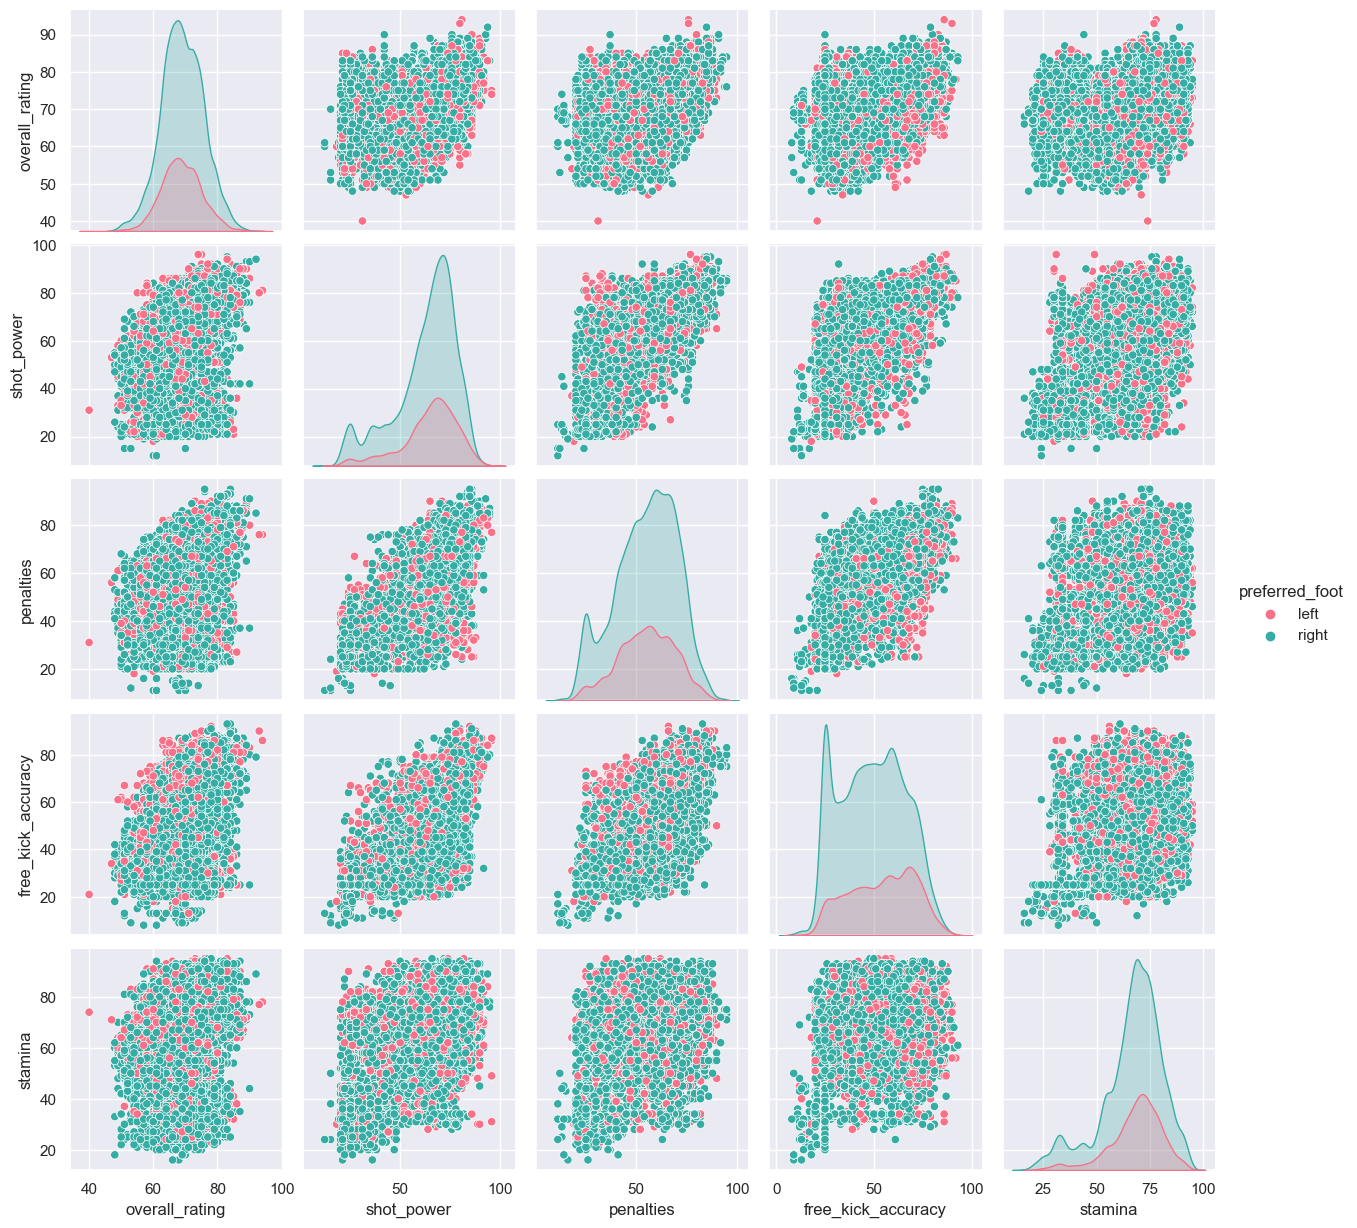

In [31]:
# pairplot without hue the car length, width and height
auto_dims = sns.pairplot(player_atts[['overall_rating', 'preferred_foot', 'shot_power', 'penalties', 'free_kick_accuracy', 
            'stamina']], hue="preferred_foot", hue_order=None, palette='husl')
                         
# to show
plt.show()

> ## 3.6 Categorical Data Analysis and Further Analysis
>> ### 3.6.1 Extracting Categorical Data

In [32]:
# get Categorical Data
categorical = player_atts.select_dtypes(include=["object"]).columns
df_cat = player_atts[categorical]
df_cat.head()

,player_name,birthday,attacking_work_rate,defensive_work_rate,preferred_foot
0,Aaron Meijers,1987-10-28 00:00:00,medium,medium,left
1,Achille Emana,1982-06-05 00:00:00,medium,low,right
2,Adam Lallana,1988-05-10 00:00:00,high,medium,right
3,Adam Morgan,1994-04-21 00:00:00,medium,medium,left
4,Adama Traore,1990-02-03 00:00:00,high,medium,left


>> ### 3.6.3 Who was the Tallest Player in 2014?

In [33]:
# Extract Player Name and Height columns
player_height = player_atts[["player_name", "height"]]

# Who was the tallest player?
player_height[player_height.height == player_height.height.max()]

,player_name,height
271,Kristof van Hout,208.28


$Observation$
- **Kristof van Hout** was the tallest player, standing at $2.1$ meters. 

>> ### 3.6.4 Who was the Oldest Player in 2014?

In [34]:
# Surpres warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = 'warn'
# Extract Player Name and birthday
player_age = player_atts[["player_name", "birthday"]]

# Covert Birthday Column to date format
player_age['birthday'] = pd.to_datetime(player_age['birthday'])

# Generating age
then = pd.Timestamp('2014') # set year to 2014
player_age['birthday'] = player_age['birthday'].where(player_age['birthday'] < then, player_age['birthday'] -  np.timedelta64(100, 'Y'))   # 2
player_age['age'] = (then - player_age['birthday']).astype('<m8[Y]')
 
# Check if the above worked
player_age.head()

,player_name,birthday,age
0,Aaron Meijers,1987-10-28,26.0
1,Achille Emana,1982-06-05,31.0
2,Adam Lallana,1988-05-10,25.0
3,Adam Morgan,1994-04-21,19.0
4,Adama Traore,1990-02-03,23.0


In [35]:
# Now get the olders pplayer in 2014
# Who was the oldest player in 2014?
player_age[player_age.age == player_age.age.max()].drop_duplicates()

,player_name,birthday,age
583,Brad Friedel,1971-05-18,42.0


$Observation$
- **Brad Friedel** was the oldest player in $2014$. 

>> ### 3.6.5 Who were the youngest players in 2014?


In [36]:
# Who was the youngest player in 2014?
player_age[player_age.age == player_age.age.min()].drop_duplicates()

,player_name,birthday,age
2332,Greg Kiltie,1997-01-18,16.0
5110,Adam Armstrong,1997-02-10,16.0
7296,Michal Walski,1997-02-27,16.0
7680,Daniel De Silva,1997-03-06,16.0
8057,Patrick Roberts,1997-02-05,16.0
8271,Allan Saint-Maximin,1997-03-12,16.0
8437,Dawid Kownacki,1997-03-14,16.0
9038,Albian Ajeti,1997-02-26,16.0
9139,Breel Embolo,1997-02-14,16.0
14015,Malcom,1997-02-26,16.0


$Observation$
- We get a whooping 38 young players in 2014.


In [37]:
players_height = pd.read_sql("""SELECT CASE
                                        WHEN ROUND(height)<165 then 165
                                        WHEN ROUND(height)>195 then 195
                                        ELSE ROUND(height)
                                        END AS calc_height, 
                                        COUNT(height) AS distribution, 
                                        (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating,
                                        (avg(PA_Grouped.avg_potential)) AS avg_potential,
                                        AVG(weight) AS avg_weight 
                            FROM PLAYER
                            LEFT JOIN (SELECT Player_Attributes.player_api_id, 
                                        avg(Player_Attributes.overall_rating) AS avg_overall_rating,
                                        avg(Player_Attributes.potential) AS avg_potential  
                                        FROM Player_Attributes
                                        GROUP BY Player_Attributes.player_api_id) 
                                        AS PA_Grouped ON PLAYER.player_api_id = PA_Grouped.player_api_id
                            GROUP BY calc_height
                            ORDER BY calc_height
                                ;""", database_connection)

>> ### 3.6.7 Attack-Minded Players

In [38]:
df_cat.head(1)

,player_name,birthday,attacking_work_rate,defensive_work_rate,preferred_foot
0,Aaron Meijers,1987-10-28 00:00:00,medium,medium,left


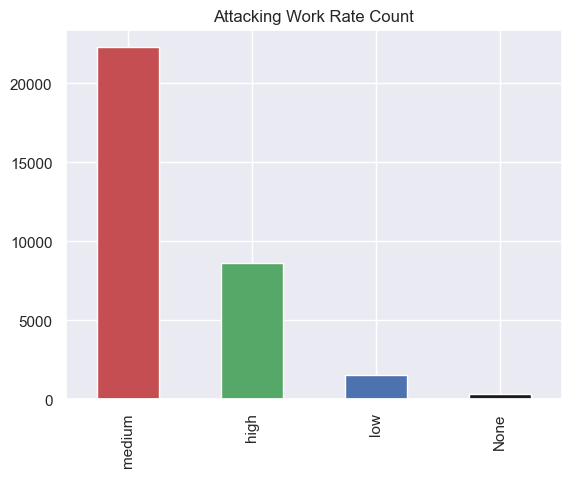

In [39]:
awr = pd.DataFrame(player_atts['attacking_work_rate'].value_counts())
awr
# Plot Workrate Distribution
my_colors = 'rgbkymc'  # blue,green.
ax = player_atts['attacking_work_rate'].value_counts().plot(kind='bar', color=list(my_colors), title = "Attacking Work Rate Count")
plt.show()

---
---
# <center>4. Manchester United vs. Manchester City</center>

Let's see how the mighty Manchester teams fared from $2010$ to $2015$. 

> ## 4.1 A look at `Team`  Table

In [40]:
# Show All Columns
pd.set_option('display.max_columns', None)
# Take a look at Team Dataframe
Team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


> ## 4.2 A look at `Team_Attributes`  Table

In [41]:
# Take a look at Team_Attributes Dataframe
Team_Attributes.head(3)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover


> ## 4.3 Let's `LEFT JOIN` `Team` Table with `Team_Attributes` Table and check some entries.

In [42]:
teams = pd.read_sql("""SELECT * 
                                FROM Team
                                LEFT JOIN Team_Attributes
                                ON Team_Attributes.team_api_id = Team.team_api_id
                                """, database_connection)
# Check the first 3 entries
teams.head(3)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,9987,673.0,KRC Genk,GEN,485.0,673.0,9987.0,2010-02-22 00:00:00,45.0,Balanced,NaN,Little,45.0,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover
1,1,9987,673.0,KRC Genk,GEN,486.0,673.0,9987.0,2011-02-22 00:00:00,66.0,Balanced,NaN,Little,52.0,Mixed,Organised,65.0,Normal,66.0,Normal,51.0,Normal,Organised,48.0,Medium,47.0,Press,54.0,Normal,Offside Trap
2,1,9987,673.0,KRC Genk,GEN,487.0,673.0,9987.0,2012-02-22 00:00:00,53.0,Balanced,NaN,Little,55.0,Mixed,Organised,55.0,Normal,48.0,Normal,56.0,Normal,Organised,47.0,Medium,45.0,Press,55.0,Normal,Cover


> ## 4.4 Let's select Manchester United and Manchester City
- Since we want to dig some insights into Manchester teams, let's go ahead and select only those teams.

In [43]:
# Select Manchester United and City
team_stats = teams[(teams["team_long_name"]== "Manchester United") | (teams["team_long_name"] == "Manchester City") ]

> ## 4.5 Clean the data

In [44]:
# Remove Duplicate Columns
team_stats = team_stats.loc[:,~team_stats.columns.duplicated()]

# Drop some columns
team_stats = team_stats.drop(["id", "team_api_id", "team_fifa_api_id","team_short_name"], axis=1)

# Select only numerical columns
team_stats_num = team_stats[["team_long_name", "date", "buildUpPlaySpeed", "buildUpPlayPassing", "chanceCreationPassing", "chanceCreationCrossing", "chanceCreationShooting", "defencePressure", "defenceAggression", "defenceTeamWidth"]]

# Covert date Column to date format
team_stats_num['date'] = pd.to_datetime(team_stats_num['date'])

team_stats_num

,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
99,Manchester United,2010-02-22,70.0,45.0,45.0,70.0,65.0,40.0,50.0,40.0
100,Manchester United,2011-02-22,65.0,40.0,65.0,65.0,70.0,45.0,45.0,65.0
101,Manchester United,2012-02-22,46.0,54.0,46.0,60.0,55.0,40.0,50.0,56.0
102,Manchester United,2013-09-20,46.0,38.0,46.0,68.0,37.0,49.0,49.0,56.0
103,Manchester United,2014-09-19,46.0,54.0,49.0,72.0,56.0,42.0,41.0,56.0
104,Manchester United,2015-09-10,38.0,44.0,49.0,44.0,40.0,54.0,53.0,56.0
153,Manchester City,2010-02-22,70.0,60.0,55.0,70.0,70.0,45.0,55.0,45.0
154,Manchester City,2011-02-22,70.0,60.0,70.0,65.0,75.0,65.0,65.0,50.0
155,Manchester City,2012-02-22,45.0,55.0,40.0,38.0,48.0,50.0,60.0,54.0
156,Manchester City,2013-09-20,36.0,34.0,39.0,44.0,38.0,42.0,44.0,54.0


> ## 4.6 Select Only Manchester United From the above Data Frame

In [45]:
# Select Manchester United from the above dataframe
man_u = team_stats_num[(team_stats_num["team_long_name"]== "Manchester United")]
man_u

,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
99,Manchester United,2010-02-22,70.0,45.0,45.0,70.0,65.0,40.0,50.0,40.0
100,Manchester United,2011-02-22,65.0,40.0,65.0,65.0,70.0,45.0,45.0,65.0
101,Manchester United,2012-02-22,46.0,54.0,46.0,60.0,55.0,40.0,50.0,56.0
102,Manchester United,2013-09-20,46.0,38.0,46.0,68.0,37.0,49.0,49.0,56.0
103,Manchester United,2014-09-19,46.0,54.0,49.0,72.0,56.0,42.0,41.0,56.0
104,Manchester United,2015-09-10,38.0,44.0,49.0,44.0,40.0,54.0,53.0,56.0


> ## 4.7 Select Only Manchester City From the above Data Frame

In [46]:
# Select Manchester City from the above dataframe
man_city = team_stats_num[(team_stats_num["team_long_name"]== "Manchester City")]
man_city

,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
153,Manchester City,2010-02-22,70.0,60.0,55.0,70.0,70.0,45.0,55.0,45.0
154,Manchester City,2011-02-22,70.0,60.0,70.0,65.0,75.0,65.0,65.0,50.0
155,Manchester City,2012-02-22,45.0,55.0,40.0,38.0,48.0,50.0,60.0,54.0
156,Manchester City,2013-09-20,36.0,34.0,39.0,44.0,38.0,42.0,44.0,54.0
157,Manchester City,2014-09-19,59.0,29.0,32.0,49.0,62.0,42.0,44.0,54.0
158,Manchester City,2015-09-10,59.0,29.0,38.0,36.0,24.0,48.0,47.0,54.0


> ## 4.8 Put the dataframes side by side and Display their Graphs
>> ### 4.8.1 Play Buildup Speed from $2010$ to $2015$

Manchester United 
 
 
   
 date 
 buildUpPlaySpeed 
 
 
 
 
 99 
 2010-02-22 00:00:00 
 70.000000 
 
 
 100 
 2011-02-22 00:00:00 
 65.000000 
 
 
 101 
 2012-02-22 00:00:00 
 46.000000 
 
 
 102 
 2013-09-20 00:00:00 
 46.000000 
 
 
 103 
 2014-09-19 00:00:00 
 46.000000 
 
 
 104 
 2015-09-10 00:00:00 
 38.000000 
 
 
 

 
 Manchester City 
 
 
   
 buildUpPlaySpeed 
 
 
 
 
 153 
 70.000000 
 
 
 154 
 70.000000 
 
 
 155 
 45.000000 
 
 
 156 
 36.000000 
 
 
 157 
 59.000000 
 
 
 158 
 59.000000

<AxesSubplot:title={'center':'Man United vs. Man City  Buildup Play Speed Changes from 2010 to 2015'}, xlabel='date', ylabel='buildUpPlaySpeed'>

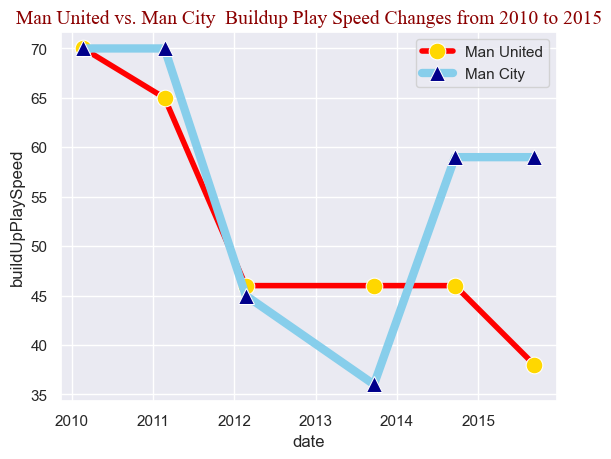

In [47]:
# Import display_html
from IPython.display import display_html 

# Man U Table
man_u_styler = man_u[["date", "buildUpPlaySpeed"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester United')

# Man City Table
man_city_styler = man_city[["buildUpPlaySpeed"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester City')

# Output the tables
display_html(man_u_styler._repr_html_()+man_city_styler._repr_html_(), raw=True)

#Graph Build Up Play Speed
sns.lineplot(x='date', y='buildUpPlaySpeed', data=man_u, marker='o', markerfacecolor="gold", markersize=12, color='red', linewidth=4, label='Man United').set_title("Man United vs. Man City  Buildup Play Speed Changes from 2010 to 2015", fontname ='Times New Roman', size = 14, color ='Darkred' )
sns.lineplot(x='date', y='buildUpPlaySpeed', data=man_city, marker='^', markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=6, label='Man City')


### $Analysis$
- From the line plots above, we observe a decline in Play buildup speed for both teams from $2010$ to $2015$, generally. 
- Machester United style reamined steady between 2012 to late 2014, after which it continued to decline. Manchester City, however, say a sharp improvement in buildup play speed after continued decline from late 2011 to late 2013, after which they improved upto late 2014, then their play got stady after that.
- No team ever went back to their initial play speed in those six years.

>> ### 4.8.2 Play Buildup Passing from $2010$ to $2015$

Manchester United 
 
 
   
 date 
 buildUpPlayPassing 
 
 
 
 
 99 
 2010-02-22 00:00:00 
 45.000000 
 
 
 100 
 2011-02-22 00:00:00 
 40.000000 
 
 
 101 
 2012-02-22 00:00:00 
 54.000000 
 
 
 102 
 2013-09-20 00:00:00 
 38.000000 
 
 
 103 
 2014-09-19 00:00:00 
 54.000000 
 
 
 104 
 2015-09-10 00:00:00 
 44.000000 
 
 
 

 
 Manchester City 
 
 
   
 buildUpPlayPassing 
 
 
 
 
 153 
 60.000000 
 
 
 154 
 60.000000 
 
 
 155 
 55.000000 
 
 
 156 
 34.000000 
 
 
 157 
 29.000000 
 
 
 158 
 29.000000

<AxesSubplot:title={'center':'Man United vs. Man City  Buildup Play Passing Changes from 2010 to 2015'}, xlabel='date', ylabel='buildUpPlayPassing'>

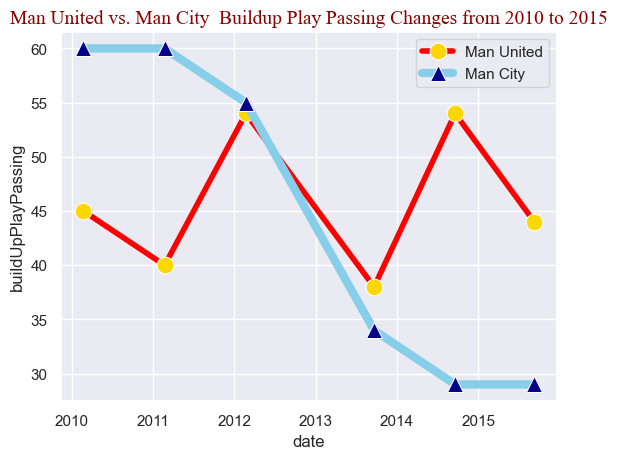

In [48]:
# Import display_html
from IPython.display import display_html 

# Man U Table
man_u_styler = man_u[["date", "buildUpPlayPassing"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester United')

# Man City Table
man_city_styler = man_city[["buildUpPlayPassing"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester City')

# Output the tables
display_html(man_u_styler._repr_html_()+man_city_styler._repr_html_(), raw=True)

#Graph Build Up Play Speed
sns.lineplot(x='date', y='buildUpPlayPassing', data=man_u, marker='o', markerfacecolor="gold", 
             markersize=12, color='red', linewidth=4, label='Man United').set_title("Man United vs. Man City  Buildup Play Passing Changes from 2010 to 2015", fontname ='Times New Roman', size = 14, color ='Darkred' )
sns.lineplot(x='date', y='buildUpPlayPassing', data=man_city, marker='^', markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=6, label='Man City')


### $Analysis$
- Manchester City's build up passing plummeted between $2010$ and $2015$, while that of Manchester United fluctuated year to year, improving from $2010$ to $2011$, then falling again before raising in the new season; by end of $2015$ season their build up play was tumbling down again.
- Generally, United improved their passing buildup.

>> ### 4.8.3 Passing Threat
- #### Chance Creation Passing from $2010$ to $2015$
- - What is it? This is making a pass that results in a shot; so we want to analyze which team was better at this between $2010$ and $2015$. 

Manchester United 
 
 
   
 date 
 chanceCreationPassing 
 
 
 
 
 99 
 2010-02-22 00:00:00 
 45.000000 
 
 
 100 
 2011-02-22 00:00:00 
 65.000000 
 
 
 101 
 2012-02-22 00:00:00 
 46.000000 
 
 
 102 
 2013-09-20 00:00:00 
 46.000000 
 
 
 103 
 2014-09-19 00:00:00 
 49.000000 
 
 
 104 
 2015-09-10 00:00:00 
 49.000000 
 
 
 

 
 Manchester City 
 
 
   
 chanceCreationPassing 
 
 
 
 
 153 
 55.000000 
 
 
 154 
 70.000000 
 
 
 155 
 40.000000 
 
 
 156 
 39.000000 
 
 
 157 
 32.000000 
 
 
 158 
 38.000000

<AxesSubplot:title={'center':'Man United vs. Man City  Chance Creation Passing from 2010 to 2015'}, xlabel='date', ylabel='chanceCreationPassing'>

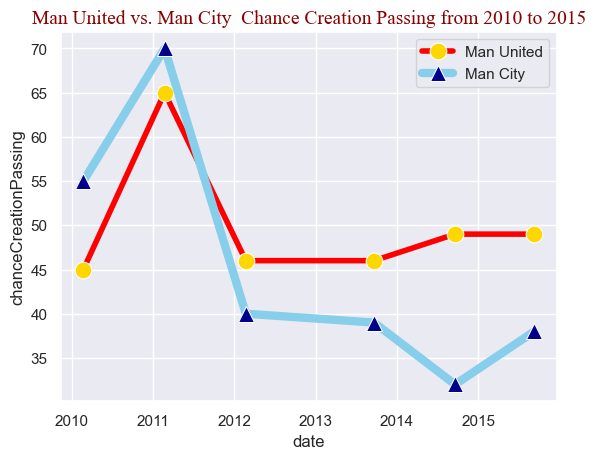

In [49]:
# Import display_html
from IPython.display import display_html 

# Man U Table
man_u_styler = man_u[["date", "chanceCreationPassing"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester United')

# Man City Table
man_city_styler = man_city[["chanceCreationPassing"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester City')

# Output the tables
display_html(man_u_styler._repr_html_()+man_city_styler._repr_html_(), raw=True)

#Graph Chance Creation Passing
sns.lineplot(x='date', y='chanceCreationPassing', data=man_u, marker='o', markerfacecolor="gold", markersize=12, color='red', linewidth=4, label='Man United').set_title("Man United vs. Man City  Chance Creation Passing from 2010 to 2015", fontname ='Times New Roman', size = 14, color ='Darkred' )
sns.lineplot(x='date', y='chanceCreationPassing', data=man_city, marker='^', markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=6, label='Man City')


### $Analysis$
- While Manchester City improved from $2010$ to $2011$, Manchester United's Passing lead to more threads than that of Manchester City in general.
- Both teams did poorly from $2012$ in creating more threatening passes.

>> ### 4.8.4 Crossing
- #### Chance Creation Crossing from $2010$ to $2015$

Manchester United 
 
 
   
 date 
 chanceCreationCrossing 
 
 
 
 
 99 
 2010-02-22 00:00:00 
 70.000000 
 
 
 100 
 2011-02-22 00:00:00 
 65.000000 
 
 
 101 
 2012-02-22 00:00:00 
 60.000000 
 
 
 102 
 2013-09-20 00:00:00 
 68.000000 
 
 
 103 
 2014-09-19 00:00:00 
 72.000000 
 
 
 104 
 2015-09-10 00:00:00 
 44.000000 
 
 
 

 
 Manchester City 
 
 
   
 chanceCreationCrossing 
 
 
 
 
 153 
 70.000000 
 
 
 154 
 65.000000 
 
 
 155 
 38.000000 
 
 
 156 
 44.000000 
 
 
 157 
 49.000000 
 
 
 158 
 36.000000

<AxesSubplot:title={'center':'Man United vs. Man City  Chance Creation Crossing from 2010 to 2015'}, xlabel='date', ylabel='chanceCreationCrossing'>

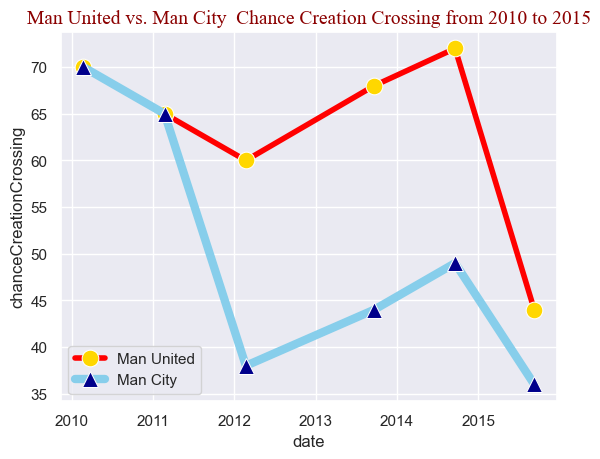

In [50]:
# Import display_html
from IPython.display import display_html 

# Man U Table
man_u_styler = man_u[["date", "chanceCreationCrossing"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester United')

# Man City Table
man_city_styler = man_city[["chanceCreationCrossing"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester City')

# Output the tables
display_html(man_u_styler._repr_html_()+man_city_styler._repr_html_(), raw=True)

#Graph Chance Creation Passing
sns.lineplot(x='date', y='chanceCreationCrossing', data=man_u, marker='o', markerfacecolor="gold", markersize=12, color='red', linewidth=4, label='Man United').set_title("Man United vs. Man City  Chance Creation Crossing from 2010 to 2015", fontname ='Times New Roman', size = 14, color ='Darkred' )
sns.lineplot(x='date', y='chanceCreationCrossing', data=man_city, marker='^', markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=6, label='Man City')


### $Analysis$
- By end of $2014$ Machester united was at its pinaccle with chances created from crosses.
- Machester City showed no significant signs of real threat from crosses.

>> ### 4.8.5 Shooting
- #### Chance Creation Shooting from $2010$ to $2015$


Manchester United 
 
 
   
 date 
 chanceCreationShooting 
 
 
 
 
 99 
 2010-02-22 00:00:00 
 65.000000 
 
 
 100 
 2011-02-22 00:00:00 
 70.000000 
 
 
 101 
 2012-02-22 00:00:00 
 55.000000 
 
 
 102 
 2013-09-20 00:00:00 
 37.000000 
 
 
 103 
 2014-09-19 00:00:00 
 56.000000 
 
 
 104 
 2015-09-10 00:00:00 
 40.000000 
 
 
 

 
 Manchester City 
 
 
   
 chanceCreationShooting 
 
 
 
 
 153 
 70.000000 
 
 
 154 
 75.000000 
 
 
 155 
 48.000000 
 
 
 156 
 38.000000 
 
 
 157 
 62.000000 
 
 
 158 
 24.000000

<AxesSubplot:title={'center':'Man United vs. Man City  Chance Creation Shooting from 2010 to 2015'}, xlabel='date', ylabel='chanceCreationShooting'>

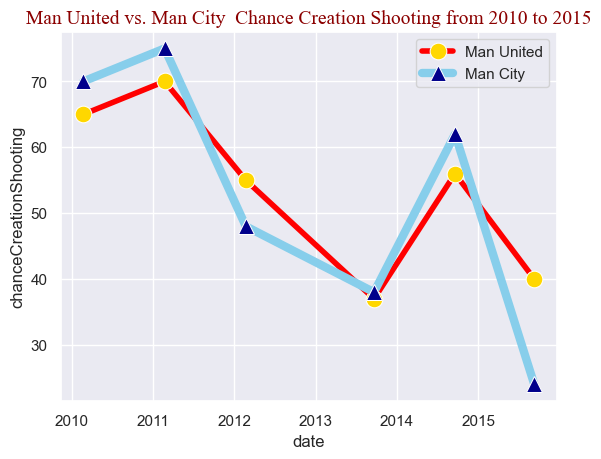

In [51]:
# Import display_html
from IPython.display import display_html 

# Man U Table
man_u_styler = man_u[["date", "chanceCreationShooting"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester United')

# Man City Table
man_city_styler = man_city[["chanceCreationShooting"]].style.set_table_attributes("style='display:inline'").set_caption('Manchester City')

# Output the tables
display_html(man_u_styler._repr_html_()+man_city_styler._repr_html_(), raw=True)

#Graph Chance Creation Passing
sns.lineplot(x='date', y='chanceCreationShooting', data=man_u, marker='o', markerfacecolor="gold", markersize=12, color='red', linewidth=4, label='Man United').set_title("Man United vs. Man City  Chance Creation Shooting from 2010 to 2015", fontname ='Times New Roman', size = 14, color ='Darkred' )
sns.lineplot(x='date', y='chanceCreationShooting', data=man_city, marker='^', markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=6, label='Man City')

### $Analysis$
- Both teams started off well going into $2011$, reaching $65$% and $70$% respectively
- But from $2011$ to $2014$ their shooting chances plummeted and never reached the level of $2011$ despite improvements, before yet another fall moving to the end of $2015$ season. 

> ## 4.9 `Group By` to get average of each feature over 6 years

In [52]:
# Groupby team name
team_stats_num.groupby("team_long_name").mean().round(1).T

team_long_name,Manchester City,Manchester United
buildUpPlaySpeed,56.5,51.8
buildUpPlayPassing,44.5,45.8
chanceCreationPassing,45.7,50.0
chanceCreationCrossing,50.3,63.2
chanceCreationShooting,52.8,53.8
defencePressure,48.7,45.0
defenceAggression,52.5,48.0
defenceTeamWidth,51.8,54.8


### $Analysis$

The above 6-year averages for each feature give us an insight into each team, grouped by country.
- Manchester City's Average Buildup Play **Speed** was better than that of Machester United over the four years ($2010$ to $2015.$
- When it comes to Buildup Play **Passing**, Manchester United's $2010$ to $2015$ Average was better than that of Manchester City. 
- Manchester United created more average chances from their passing than Manchester City. 
- Again, Machester United was more prolific in creating Crossing chances, averaging $63.2$% to $50.2$% of Manchester City.
- Between $2010$ and $2015$, we see once again that Manchester United was just about $1$% better than Manchester City with creating shooting chances. 
- However, between $2010$ and $2015$, Machester City played a more pressure-focused and aggressive defensive game than Machester United. 
- Manchester United used a more widened defence technique between $2010$ and $2015$ than Manchester City. 


> ## 4.10 Manchester United Style of Play Statistics Visualization
>> ### 4.10.1 Multiple Line Plots

<AxesSubplot:xlabel='date', ylabel='defenceTeamWidth'>

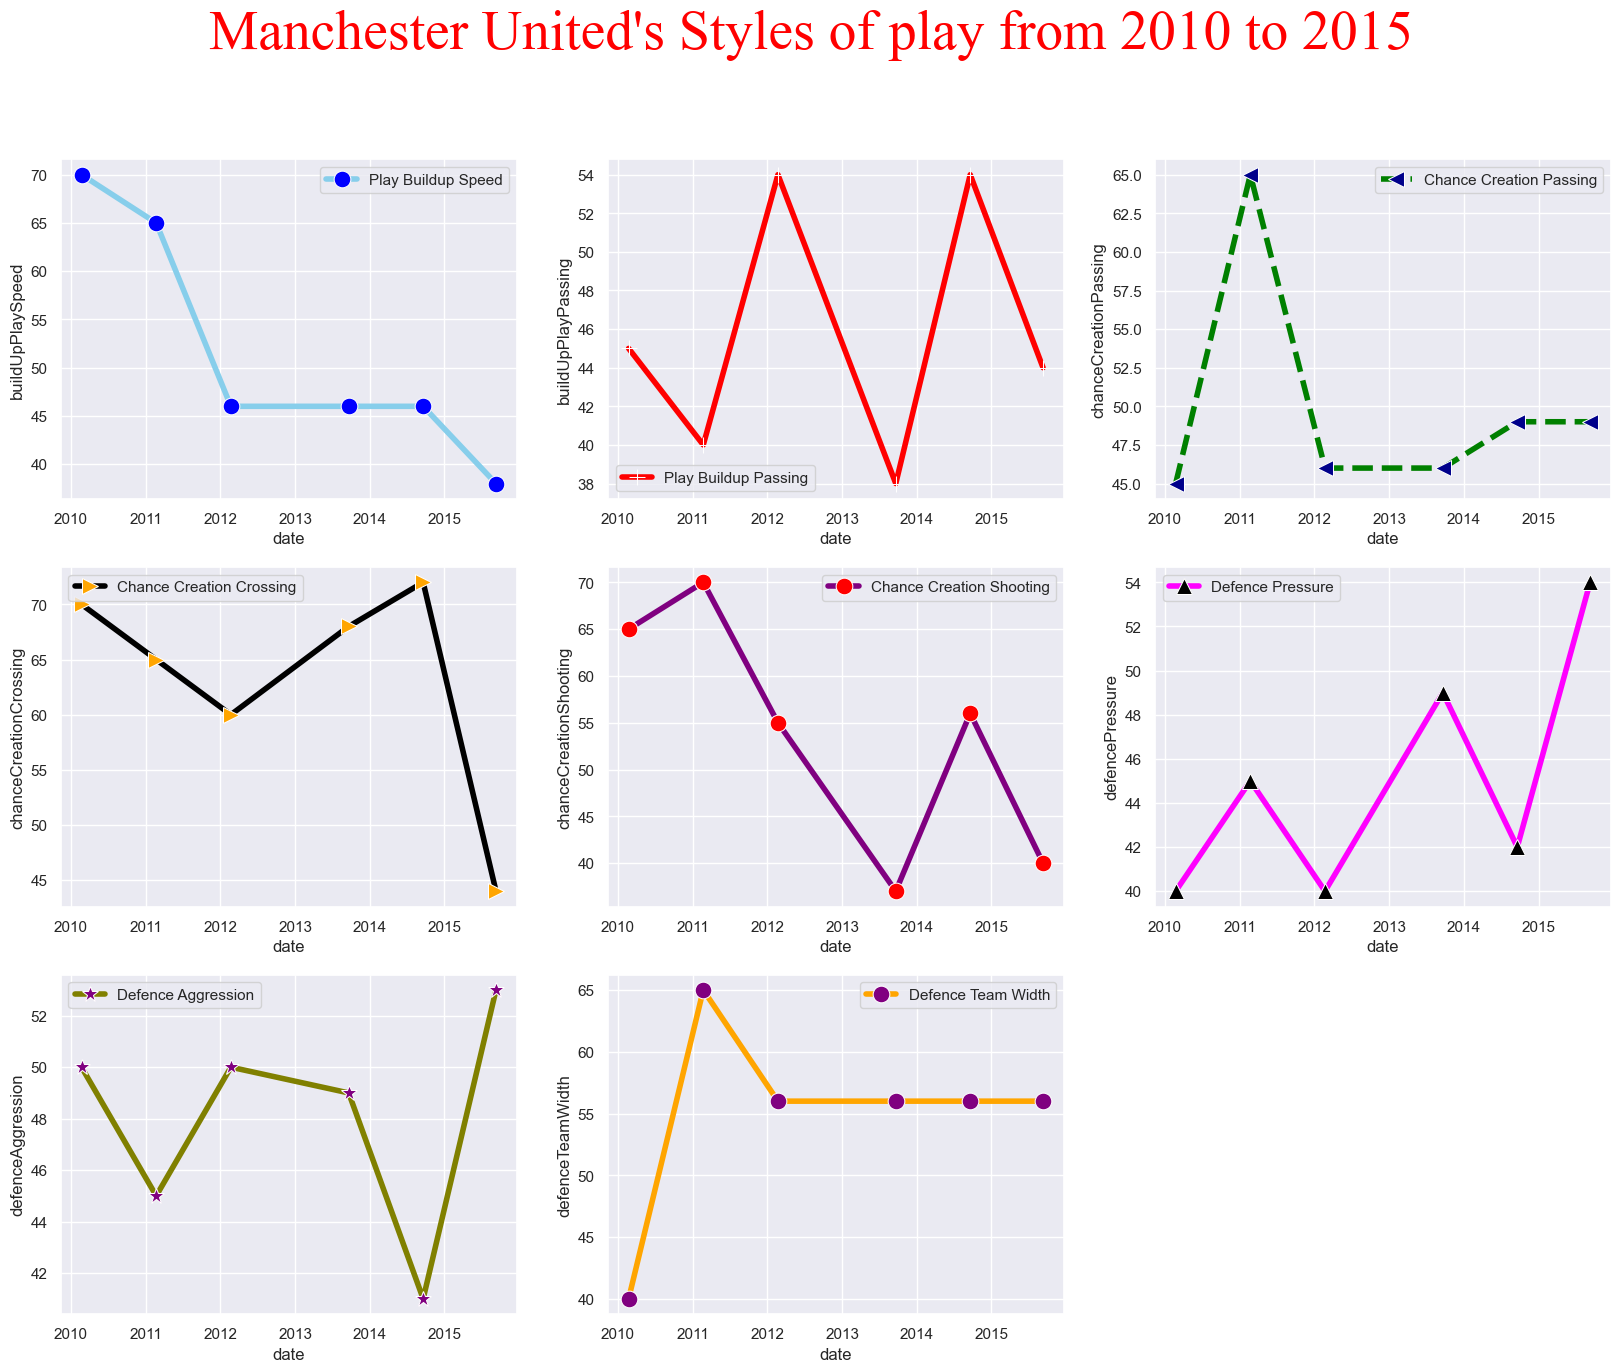

In [53]:
# Set figure size
plt.figure(figsize=(20, 15))
#Set Plot Title for all subplots
plt.suptitle("Manchester United's Styles of play from 2010 to 2015", fontname ='Times New Roman', size = 40, color ='red')

# Multiple Plots
# Play Buildup Play Speed Graph
plt.subplot(3,3,1)
sns.lineplot(x='date', y='buildUpPlaySpeed', data=man_u, marker='o', markerfacecolor="blue", markersize=12, color='skyblue', linewidth=4, label='Play Buildup Speed')
plt.subplot(3,3,2)
sns.lineplot(x='date', y='buildUpPlayPassing', data=man_u, marker='+', markerfacecolor="black", markersize=12, color='red', linewidth=4, label='Play Buildup Passing')
plt.subplot(3,3,3)
sns.lineplot(x='date', y='chanceCreationPassing', data=man_u, marker='<', markerfacecolor="darkblue", markersize=12, color='green', linewidth=4, label='Chance Creation Passing', linestyle='dashed')
plt.subplot(3,3,4)
sns.lineplot(x='date', y='chanceCreationCrossing', data=man_u, marker='>', markerfacecolor="orange", markersize=12, color='black', linewidth=4, label='Chance Creation Crossing', ci=None)
plt.subplot(3,3,5)
sns.lineplot(x='date', y='chanceCreationShooting', data=man_u, marker='o', markerfacecolor="red", markersize=12, color='purple', linewidth=4, label='Chance Creation Shooting', palette='deep')
plt.subplot(3,3,6)
sns.lineplot(x='date', y='defencePressure', data=man_u, marker='^', markerfacecolor="black", markersize=12, color='magenta', linewidth=4, label='Defence Pressure')
plt.subplot(3,3,7)
sns.lineplot(x='date', y='defenceAggression', data=man_u, marker='*', markerfacecolor="purple", markersize=12, color='olive', linewidth=4, label='Defence Aggression')
plt.subplot(3,3,8)
sns.lineplot(x='date', y='defenceTeamWidth', data=man_u, marker='o', markerfacecolor="purple", markersize=12, color='orange', linewidth=4, label='Defence Team Width')

> ## 4.11 Manchester City Style of Play Statistics Visualization
>> ### 4.11.1 Multiple Line Plots

Text(0.5, 1.0, 'Defence Team Width')

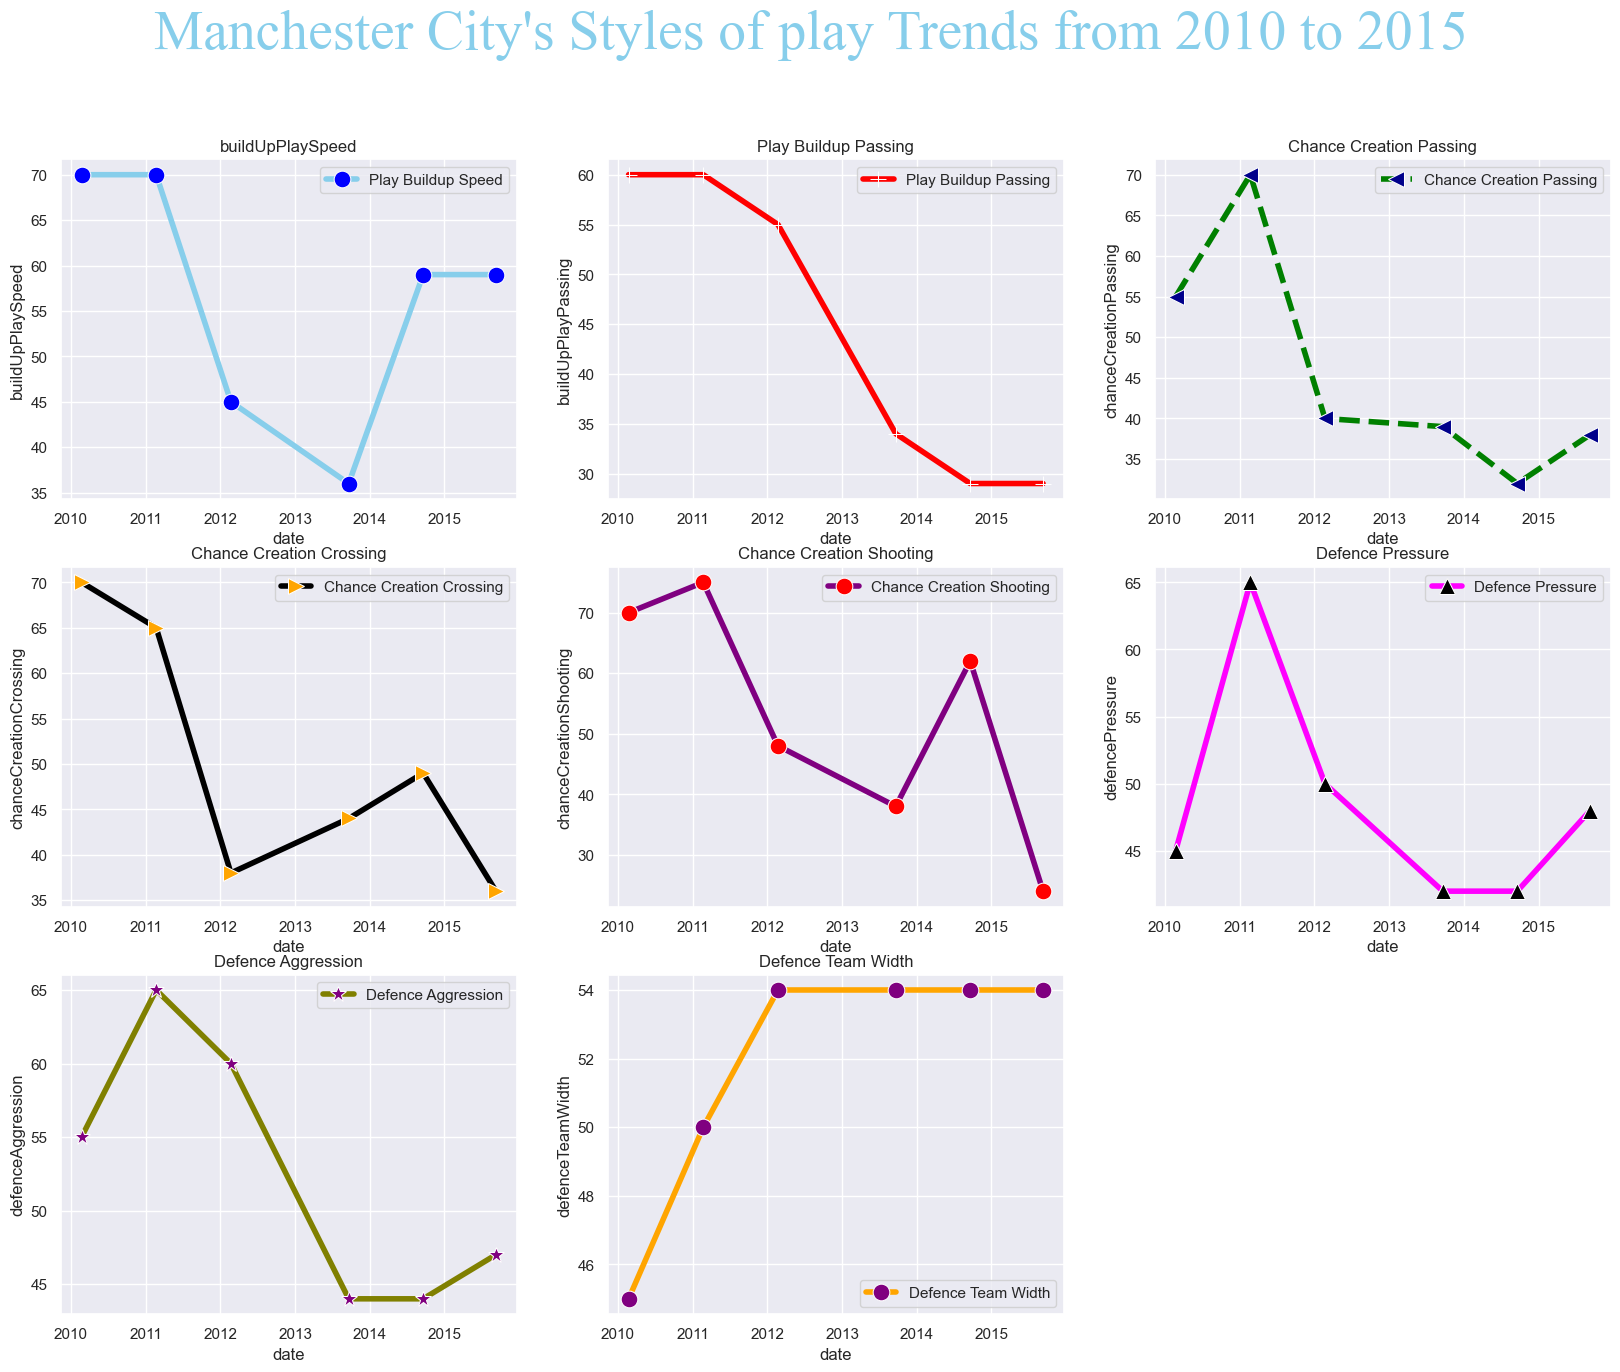

In [54]:
# Set figure size
plt.figure(figsize=(20, 15))
#Set Plot Title for all subplots
plt.suptitle("Manchester City's Styles of play Trends from 2010 to 2015", fontname ='Times New Roman', size = 40, color ='skyblue')
# Tight Layout
plt.tight_layout()
# Multiple Plots
# Play Buildup Play Speed Graph
plt.subplot(3,3,1)
sns.lineplot(x='date', y='buildUpPlaySpeed', data=man_city, marker='o', markerfacecolor="blue", markersize=12, color='skyblue', linewidth=4, label='Play Buildup Speed').set_title("buildUpPlaySpeed")
plt.subplot(3,3,2)
sns.lineplot(x='date', y='buildUpPlayPassing', data=man_city, marker='+', markerfacecolor="black", markersize=12, color='red', linewidth=4, label='Play Buildup Passing').set_title("Play Buildup Passing")
plt.subplot(3,3,3)
sns.lineplot(x='date', y='chanceCreationPassing', data=man_city, marker='<', markerfacecolor="darkblue", markersize=12, color='green', linewidth=4, label='Chance Creation Passing', linestyle='dashed').set_title("Chance Creation Passing")
plt.subplot(3,3,4)
sns.lineplot(x='date', y='chanceCreationCrossing', data=man_city, marker='>', markerfacecolor="orange", markersize=12, color='black', linewidth=4, label='Chance Creation Crossing', ci=None).set_title("Chance Creation Crossing")
plt.subplot(3,3,5)
sns.lineplot(x='date', y='chanceCreationShooting', data=man_city, marker='o', markerfacecolor="red", markersize=12, color='purple', linewidth=4, label='Chance Creation Shooting', palette='deep').set_title("Chance Creation Shooting")
plt.subplot(3,3,6)
sns.lineplot(x='date', y='defencePressure', data=man_city, marker='^', markerfacecolor="black", markersize=12, color='magenta', linewidth=4, label='Defence Pressure').set_title("Defence Pressure")
plt.subplot(3,3,7)
sns.lineplot(x='date', y='defenceAggression', data=man_city, marker='*', markerfacecolor="purple", markersize=12, color='olive', linewidth=4, label='Defence Aggression').set_title("Defence Aggression")
plt.subplot(3,3,8)
sns.lineplot(x='date', y='defenceTeamWidth', data=man_city, marker='o', markerfacecolor="purple", markersize=12, color='orange', linewidth=4, label='Defence Team Width').set_title("Defence Team Width")

# Tight Layout
#plt.tight_layout()

---
---
# <center>5. Matches & Goals Analysis</cemter>
> ## 5.1 Read SQL Tables

In [55]:
match_results = pd.read_sql("""SELECT Match.id, 
                                      Country.name  country_name,
                                      League.name  League_name,
                                      date, 
                                      season,
                                      Home_team.team_long_name  Home_team,
                                      away_team.team_long_name  away_team,
                                      home_team_goal,
                                      away_team_goal
                                      
                               FROM Country 
                               JOIN Match
                               ON Country.id=Match.Country_id
                               
                               JOIN League
                               ON Country.id=League.Country_id
                        
                               LEFT JOIN Team AS Home_team 
                               ON Home_team.team_api_id=Match.home_team_api_id
                        
                               LEFT JOIN Team AS away_team 
                               ON away_team.team_api_id=Match.away_team_api_id
                        
                            """, database_connection)
match_results.head(3)

,id,country_name,League_name,date,season,Home_team,away_team,home_team_goal,away_team_goal
0,1,Belgium,Belgium Jupiler League,2008-08-17 00:00:00,2008/2009,KRC Genk,Beerschot AC,1,1
1,2,Belgium,Belgium Jupiler League,2008-08-16 00:00:00,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0
2,3,Belgium,Belgium Jupiler League,2008-08-16 00:00:00,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3


> ## 5.2 Extract Manchester United and Manchester City's Results
>> ### 5.2.1 Machester United Matches

In [56]:
# Manchester United Home Games
manU_home = match_results[match_results["Home_team"] == "Manchester United"]

# Manchester United Away Games
manU_away = match_results[match_results["away_team"] == "Manchester United"]

manU_home["match_result"] = np.where(manU_home["home_team_goal"] > manU_home["away_team_goal"], 'win', 'lose')


manU_home['match_result'] = np.where(manU_home['home_team_goal'] == manU_home['away_team_goal'], 'draw', manU_home['match_result'])


manU_away['match_result'] = np.where(manU_away['home_team_goal'] < manU_away['away_team_goal'], 'win', 'lose')
manU_away['match_result'] = np.where(manU_away['home_team_goal'] == manU_away['away_team_goal'], 'draw', manU_away['match_result'])

MU = pd.concat([manU_home, manU_away])
MU.head()

,id,country_name,League_name,date,season,Home_team,away_team,home_team_goal,away_team_goal,match_result
1728,1729,England,England Premier League,2008-08-17 00:00:00,2008/2009,Manchester United,Newcastle United,1,1,draw
1738,1739,England,England Premier League,2008-10-29 00:00:00,2008/2009,Manchester United,West Ham United,2,0,win
1748,1749,England,England Premier League,2008-11-01 00:00:00,2008/2009,Manchester United,Hull City,4,3,win
1768,1769,England,England Premier League,2008-11-15 00:00:00,2008/2009,Manchester United,Stoke City,5,0,win
1798,1799,England,England Premier League,2008-12-06 00:00:00,2008/2009,Manchester United,Sunderland,1,0,win


>> ### 5.2.2 Machester City Matches

In [57]:
# Manchester City Home Games
manC_home = match_results[match_results["Home_team"] == "Manchester City"]

# Manchester Away Away Games
manC_away = match_results[match_results["away_team"] == "Manchester City"]

manC_home["match_result"] = np.where(manC_home["home_team_goal"] > manC_home["away_team_goal"], 'win', 'lose')


manC_home['match_result'] = np.where(manC_home['home_team_goal'] == manC_home['away_team_goal'], 'draw', manC_home['match_result'])


manC_away['match_result'] = np.where(manC_away['home_team_goal'] < manC_away['away_team_goal'], 'win', 'lose')
manC_away['match_result'] = np.where(manC_away['home_team_goal'] == manC_away['away_team_goal'], 'draw', manC_away['match_result'])

MC = pd.concat([manC_home, manC_away])
MC.head()

,id,country_name,League_name,date,season,Home_team,away_team,home_team_goal,away_team_goal,match_result
1763,1764,England,England Premier League,2008-11-09 00:00:00,2008/2009,Manchester City,Tottenham Hotspur,1,2,lose
1783,1784,England,England Premier League,2008-11-22 00:00:00,2008/2009,Manchester City,Arsenal,3,0,win
1793,1794,England,England Premier League,2008-11-30 00:00:00,2008/2009,Manchester City,Manchester United,0,1,lose
1813,1814,England,England Premier League,2008-12-13 00:00:00,2008/2009,Manchester City,Everton,0,1,lose
1833,1834,England,England Premier League,2008-12-26 00:00:00,2008/2009,Manchester City,Hull City,5,1,win


> ## 5.3 Match Results Analysis 
- We look at how many Draws, Wins and Loses Each team hard; we will make use of both visual aids and actual numbers to get a full picture.

>> ### 5.3.1 Count Plots
- Count plot is a graphical display to show the number of occurrences or frequency for each categorical data using bars.
- Here we will use count plots to diplay the number of `wins`, `loses` and `draws` for each team.

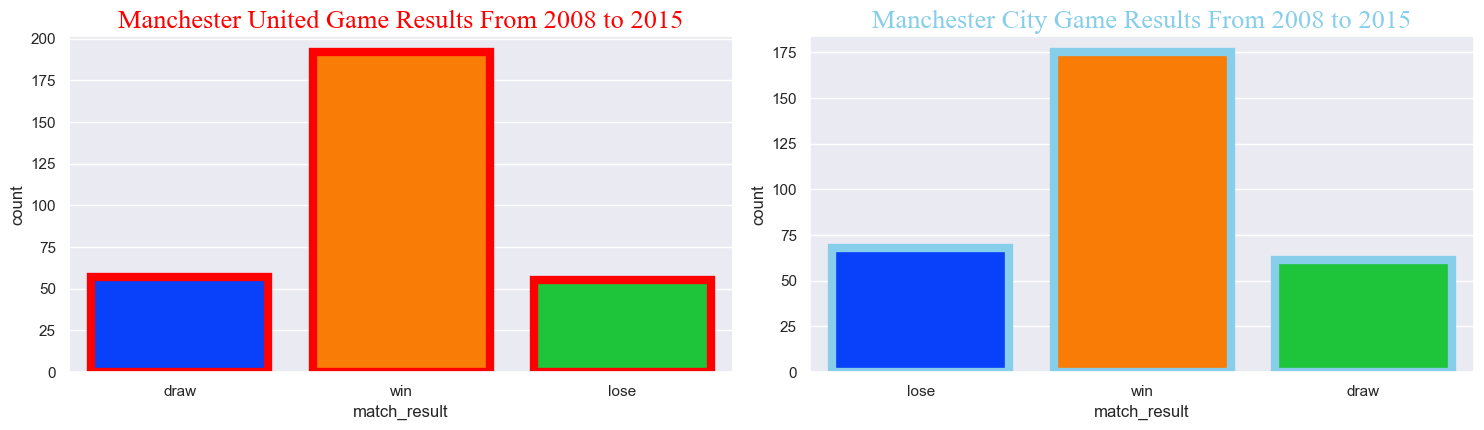

In [58]:
# Set figure size
plt.figure(figsize=(15, 8))
# Manchester United Game Results between 2008 and 2015
plt.subplot(2,2,1)
sns.countplot(x="match_result", data=MU, saturation=0.95, palette="bright", edgecolor="red",
                  linewidth=6).set_title("Manchester United Game Results From 2008 to 2015", fontsize=19, fontname ='Times New Roman', color ='red')

# Manchester City Game Results between 2008 and 2015
plt.subplot(2,2,2)
sns.countplot(x="match_result", data=MC, saturation=0.95, palette="bright", edgecolor="skyblue",
                  linewidth=6).set_title("Manchester City Game Results From 2008 to 2015", fontsize=19, fontname ='Times New Roman', color ='skyblue')
# Output figures Layout  
plt.tight_layout()

>> ### 5.3.2 $Analysis$: Numbers behind the count plots 
- Let's have actual numbers to tell us how many wins, loses and draws for each team, wheather home or away.


In [59]:
# Manchester United 
# Wins
MU_wins = MU[MU["match_result"] == "win"]["match_result"].count()
# Loses
MU_loses = MU[MU["match_result"] == "lose"]["match_result"].count()
# draws
MU_draws = MU[MU["match_result"] == "draw"]["match_result"].count()

# Manchester City 
# Wins
MC_wins = MC[MC["match_result"] == "win"]["match_result"].count()
# Loses
MC_loses = MC[MC["match_result"] == "lose"]["match_result"].count()
# draws
MC_draws = MC[MC["match_result"] == "draw"]["match_result"].count()
# print statements
# wins
print("Manchester United had", MU_wins, "wins between 2008 and 2015, while Manchester City had", MC_wins)
# loses
print("Manchester United had", MU_loses, "loses between 2008 and 2015, while Manchester City had", MC_loses)
# draws
print("Manchester United had", MU_draws, "draws between 2008 and 2015, while Manchester City had", MC_draws)


Manchester United had 192 wins between 2008 and 2015, while Manchester City had 175
Manchester United had 55 loses between 2008 and 2015, while Manchester City had 68
Manchester United had 57 draws between 2008 and 2015, while Manchester City had 61


- <font size=3)>So between $2008$ and $2015$, <font color='red'>Manchester United</font> had $192$ wins, $55$ loses and $57$ draws while <font color='skyblue'>Manchester City</font> had $175$ wins, $68$ loses and $61$ draws.</font>

- <font size=3)>Manchester United performed much better than Manchester City in that timeframe.</font>
-- 

---
> ## 5.4 Goals Analysis
- Now that we have seen wins, draws and loses for each team, let us dig deeper into the number of goals each scored while playing at home and away.
>> ### 5.4.1 Total Number of Goals scored from $2008$ to $2015$

In [60]:
# Goals Scored
MU_goals = MU["home_team_goal"].sum()
MC_goals = MC["home_team_goal"].sum()

# print statements
print("Manchester United scored", MU_goals,"\nManchester City Scored",MC_goals);

Manchester United scored 498 
Manchester City Scored 547


### $Analysis$
- Manchester City scored more goals ($547$) than Manchester United ($498$) between $2008$ and $2015$.
---
>> ### 5.4.2 Total Number of Goals conceded from $2008$ to $2015$

In [61]:
# Goals Conceded
MU_conc = MU["away_team_goal"].sum()
MC_conc = MC["away_team_goal"].sum()

# print statements
print("Manchester United conceded", MU_conc,"\nManchester City conceded",MC_conc);

Manchester United conceded 364 
Manchester City conceded 366


### $Analysis$
- Manchester City conceded 2 more goals ($366$) than Manchester United ($364$) between $2008$ and $2015$.
- While Manchester City scored more goals, they always conceded more goals, something that can be traced back to their defence techniques as we saw above.

>> ### 5.4.3 Total Number of Goals scored and conceded in a single game

In [62]:
# Maximum Goals
MU_max = MU[["home_team_goal", "away_team_goal"]].max()
MC_max = MC[["home_team_goal", "away_team_goal"]].max()
# max goals scored print statements
print("Maximum number of goals scored by Manchester United In a single match:",MU_max[0])
print("Maximum number of goals scored by Manchester City In a single match:",MC_max[0])

# max goals conceded print statements
print("\nMaximum number of goals conceded by Manchester United In a single match:",MU_max[1])
print("Maximum number of goals conceded by Manchester City In a single match:",MC_max[1])

Maximum number of goals scored by Manchester United In a single match: 8
Maximum number of goals scored by Manchester City In a single match: 7

Maximum number of goals conceded by Manchester United In a single match: 6
Maximum number of goals conceded by Manchester City In a single match: 6


---
> ## 5.5 Head-to-Head Analysis
- Now let us look at the Manchester Derby Results and goals analysis.
>> ### 5.5.1 Head-To-Head Dataframe

In [63]:
# Filter the Original MU dataframe
filtered = MU.filter(items=['date','Home_team','home_team_goal', 'away_team_goal', 'away_team','match_result'])

# Covert date Column to datetime format
filtered['date'] = pd.to_datetime(filtered['date'])

# Create a variable with TRUE if away team is Manchester City
city = filtered['away_team'] == "Manchester City"

# Create a variable where TRUE when Home team is Manchester United
united = filtered['Home_team'] == "Manchester United"

filtered = filtered[united & city]
filtered


,date,Home_team,home_team_goal,away_team_goal,away_team,match_result
2018,2009-05-10,Manchester United,2,0,Manchester City,win
2448,2009-09-20,Manchester United,4,3,Manchester City,win
2678,2011-02-12,Manchester United,2,1,Manchester City,win
3244,2011-10-23,Manchester United,1,6,Manchester City,lose
3500,2013-04-08,Manchester United,1,2,Manchester City,lose
3832,2014-03-25,Manchester United,0,3,Manchester City,lose
4260,2015-04-12,Manchester United,4,2,Manchester City,win
4403,2015-10-25,Manchester United,0,0,Manchester City,draw


>> ### 5.5.2 Manchester Derby Results between $2008$ and $2015$
- Which team between Manchester United and Manchester City won more matches in the Manchester Derby?

In [64]:
print("Machester United game results against Manchester City:")
pd.DataFrame(filtered['match_result'].value_counts())

Machester United game results against Manchester City:


,match_result
win,4
lose,3
draw,1


### $Analysis$
- Manchester United won 4 games, lost 3 games and drew 1 between $2008$ and $2015$ against Manchester City.
- Manchester United dominated the Manchester Derby between $2008$ and $2015$.
---
>> ### 5.5.3 Manchester Derby Highest Number of goals scored between $2008$ and $2015$

In [65]:
pd.DataFrame(filtered[['home_team_goal', 'away_team_goal']].max()).T

,home_team_goal,away_team_goal
0,4,6


### $Analysis$
- Manchester City's highest derby win ended with 6 goals while Manchester United's is 4 goals- of course in different derby encounters.

---
---
# <center>6. Cristiano Ronaldo vs. Lionel Messi</center>
Time to see some stats for the Argentine and Barcelona forward Lionel Messi and Portuguese and Juventus forward Christiano Ronaldo.

> ## 6.1 Read SQL Tables, Selecting players by name

In [66]:
# Read Cristiano's Data from the database
cris = pd.read_sql("""SELECT player_name,
                                  date,overall_rating,
                                  attacking_work_rate,
                                  crossing,
                                  finishing,
                                  shot_power,
                                  heading_accuracy,
                                  free_kick_accuracy,
                                  sprint_speed,
                                  dribbling,
                                  agility
                                    
                      FROM Player 
                      LEFT JOIN Player_Attributes
                      ON Player.player_api_id = Player_Attributes.player_api_id
                    
                      WHERE player_name = 'Cristiano Ronaldo'
                        
                      ORDER by date
                      """, database_connection)

# Read Messi's Data from the database
messi = pd.read_sql("""SELECT player_name,
                                  date,overall_rating,
                                  attacking_work_rate,
                                  crossing,
                                  finishing,
                                  shot_power,
                                  heading_accuracy,
                                  free_kick_accuracy,
                                  sprint_speed,
                                  dribbling,
                                  agility
                                    
                      FROM Player 
                      LEFT JOIN Player_Attributes
                      ON Player.player_api_id = Player_Attributes.player_api_id
                    
                      WHERE player_name = 'Lionel Messi'
                        
                      ORDER by date
                      """, database_connection)
# Covert date column
cris["date"] = pd.to_datetime(cris["date"])
messi["date"] = pd.to_datetime(messi["date"])

> ## 6.2 View the first 5 entries in each player's dataframe
>> ### 6.2.1 Cristiano Ronaldo's Table

In [67]:
cris.head()

,player_name,date,overall_rating,attacking_work_rate,crossing,finishing,shot_power,heading_accuracy,free_kick_accuracy,sprint_speed,dribbling,agility
0,Cristiano Ronaldo,2007-02-22,87,high,80,71,80,74,64,93,95,94
1,Cristiano Ronaldo,2007-08-30,91,high,88,85,90,84,88,94,97,94
2,Cristiano Ronaldo,2008-08-30,91,high,89,92,92,82,94,94,97,94
3,Cristiano Ronaldo,2009-02-22,90,high,89,91,90,82,93,94,97,94
4,Cristiano Ronaldo,2009-08-30,89,high,86,90,91,88,88,92,93,94


>> ### 6.2.2 Lionel Messi's Table

In [68]:
messi.head()

,player_name,date,overall_rating,attacking_work_rate,crossing,finishing,shot_power,heading_accuracy,free_kick_accuracy,sprint_speed,dribbling,agility
0,Lionel Messi,2007-02-22,85,high,85,76,83,59,87,94,95,96
1,Lionel Messi,2007-08-30,86,high,83,80,84,63,70,95,95,96
2,Lionel Messi,2008-08-30,90,high,81,87,82,64,70,95,97,96
3,Lionel Messi,2009-02-22,90,high,81,87,79,64,76,93,97,96
4,Lionel Messi,2009-08-30,90,high,82,90,79,64,74,93,97,96


> ## 6.3 Summary Statistics for Both Players
>> ### 6.3.1 Cristiano Ronaldo's Summary Statitics

In [69]:
cris.describe()

,overall_rating,crossing,finishing,shot_power,heading_accuracy,free_kick_accuracy,sprint_speed,dribbling,agility
count,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,91.280000,83.880000,91.12000,92.760000,85.520000,81.640000,93.760000,92.640000,92.960000
std,1.541644,2.107922,4.85043,2.976015,2.785678,6.467096,0.522813,2.196209,1.206924
min,87.000000,80.000000,71.00000,80.000000,74.000000,64.000000,92.000000,90.000000,90.000000
25%,91.000000,83.000000,90.00000,93.000000,86.000000,79.000000,94.000000,90.000000,93.000000
50%,92.000000,83.000000,92.00000,94.000000,86.000000,79.000000,94.000000,93.000000,93.000000
75%,92.000000,84.000000,95.00000,94.000000,87.000000,87.000000,94.000000,93.000000,94.000000
max,93.000000,89.000000,95.00000,95.000000,88.000000,94.000000,94.000000,97.000000,94.000000


>> ### 6.3.3 Lionel Messi's Summary Statitics

In [70]:
messi.describe()

,overall_rating,crossing,finishing,shot_power,heading_accuracy,free_kick_accuracy,sprint_speed,dribbling,agility
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,92.192308,83.346154,92.230769,80.307692,69.269231,84.115385,90.846154,96.461538,94.384615
std,2.545887,1.671940,5.077855,1.192283,3.606191,6.426986,2.091742,0.646886,1.267341
min,85.000000,80.000000,76.000000,79.000000,59.000000,70.000000,88.000000,95.000000,92.000000
25%,90.000000,82.250000,91.250000,80.000000,69.000000,82.000000,90.000000,96.000000,94.000000
50%,93.000000,84.000000,93.500000,80.000000,71.000000,86.000000,90.000000,97.000000,94.000000
75%,94.000000,84.000000,94.750000,80.750000,71.000000,90.000000,92.000000,97.000000,96.000000
max,94.000000,85.000000,97.000000,84.000000,73.000000,90.000000,95.000000,97.000000,96.000000


> ## 6.4 Dates under consideration
- Let's see the dates included in this dataset

In [71]:
print("Data for both players is from", cris["date"].min(), "to", messi["date"].max())

Data for both players is from 2007-02-22 00:00:00 to 2015-12-17 00:00:00


* So data is from $22/02/2007$ to $17/12/2015$.
* This is about 8 years worth of data.

> ## 6.5 Data Visualization and Analysis

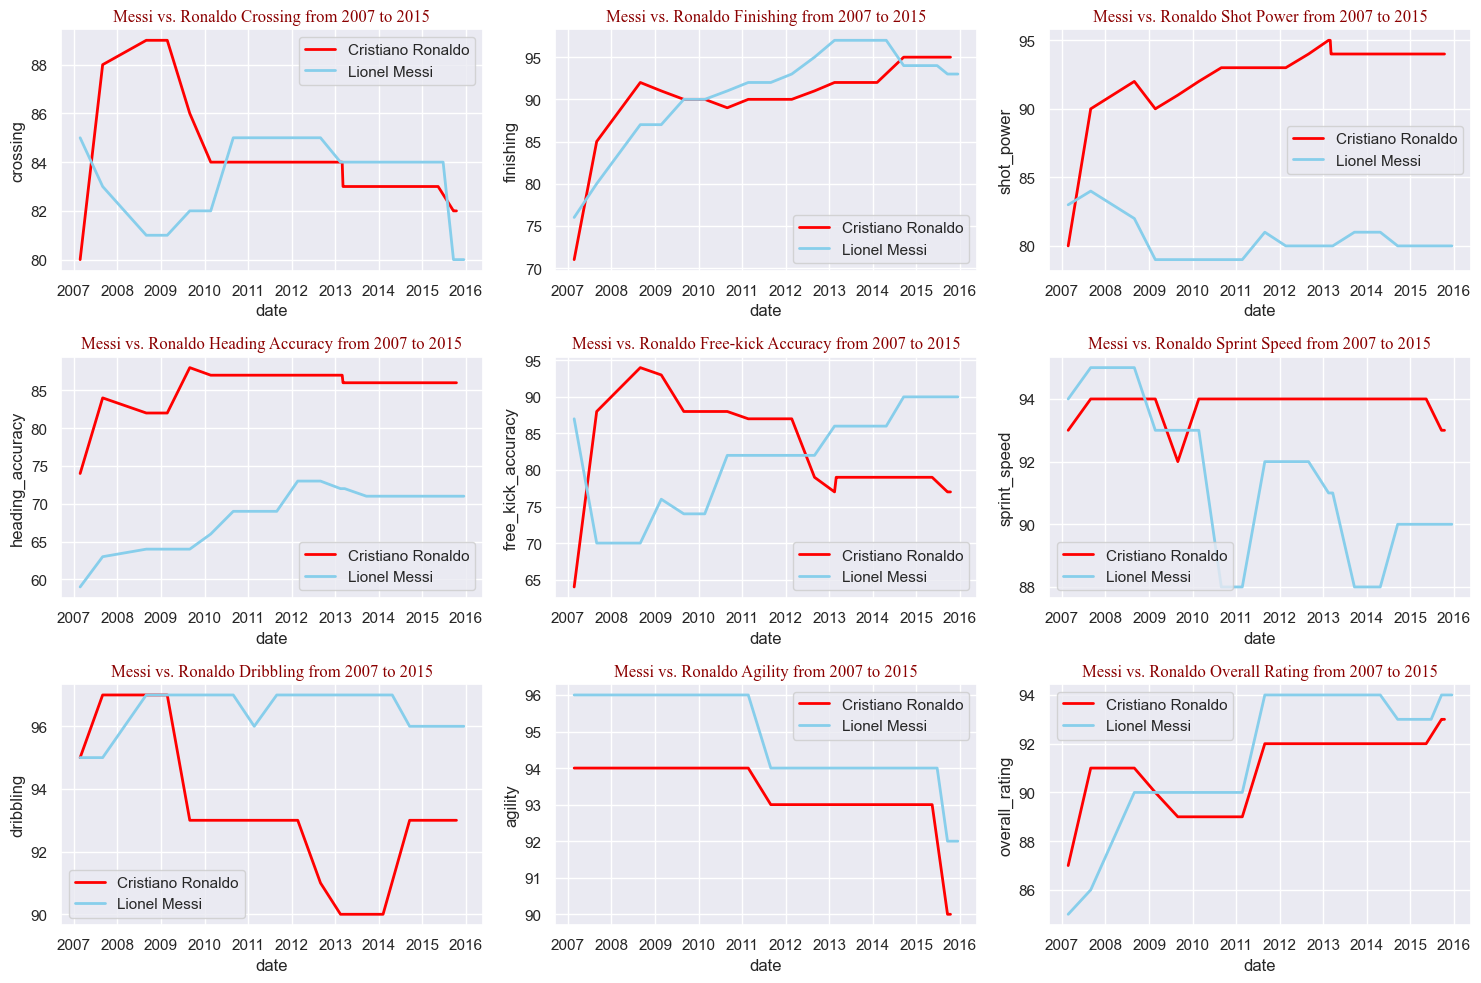

In [72]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
sns.lineplot(x='date', y='crossing', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Crossing from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='crossing', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.subplot(3,3,2)
sns.lineplot(x='date', y='finishing', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Finishing from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='finishing', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.subplot(3,3,3)
sns.lineplot(x='date', y='shot_power', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Shot Power from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='shot_power', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')


plt.subplot(3,3,4)
sns.lineplot(x='date', y='heading_accuracy', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Heading Accuracy from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='heading_accuracy', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.subplot(3,3,5)
sns.lineplot(x='date', y='free_kick_accuracy', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Free-kick Accuracy from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='free_kick_accuracy', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.subplot(3,3,6)
sns.lineplot(x='date', y='sprint_speed', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Sprint Speed from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='sprint_speed', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.subplot(3,3,7)
sns.lineplot(x='date', y='dribbling', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Dribbling from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='dribbling', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.subplot(3,3,8)
sns.lineplot(x='date', y='agility', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Agility from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='agility', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.subplot(3,3,9)
sns.lineplot(x='date', y='overall_rating', data=cris, markerfacecolor="gold", markersize=12, color='red', linewidth=2, label='Cristiano Ronaldo').set_title("Messi vs. Ronaldo Overall Rating from 2007 to 2015", fontname ='Times New Roman', size = 12, color ='Darkred' )
sns.lineplot(x='date', y='overall_rating', data=messi, markerfacecolor="darkblue", markersize=12, color='skyblue', linewidth=2, label='Lionel Messi')

plt.tight_layout()

### $Analysis$
- From 2007 Ronaldo and Messi's Overall Ratings have been rising, although Lionel Messi overtook Cristiano Ronaldo the end of 2020.

- Cristiano Ronaldo outpowered Lionel Messi on Shot Power and has been dominating since.

- We see that Lionel Messi has been a better dribbler than Cristiano Ronaldo.

- The two have been battling it out on finishing, with their graphs very close.

- Christiano Ronaldo is a better header than Messi, perharps due to the aerial advantage that Ronaldo has, compared to a shorter Messi.

- Lionel Messi improved significantly on free-kick taking, surpassing Ronaldo from mid-2012 to 2020.